# Housekeeping

In [2]:
sessionInfo()
options(repr.plot.width=14,repr.plot.antialias='subpixel',repr.plot.res=218)
update.packages()

R version 4.0.3 Patched (2020-10-12 r79333)
Platform: x86_64-apple-darwin17.0 (64-bit)
Running under: macOS Big Sur 10.16

Matrix products: default
BLAS:   /Library/Frameworks/R.framework/Versions/4.0/Resources/lib/libRblas.dylib
LAPACK: /Library/Frameworks/R.framework/Versions/4.0/Resources/lib/libRlapack.dylib

locale:
[1] en_US.UTF-8/en_US.UTF-8/en_US.UTF-8/C/en_US.UTF-8/en_US.UTF-8

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

loaded via a namespace (and not attached):
 [1] compiler_4.0.3  ellipsis_0.3.1  IRdisplay_0.7.0 pbdZMQ_0.3-3   
 [5] tools_4.0.3     htmltools_0.5.0 pillar_1.4.6    base64enc_0.1-3
 [9] crayon_1.3.4    uuid_0.1-4      IRkernel_1.1.1  jsonlite_1.7.1 
[13] digest_0.6.25   lifecycle_0.2.0 repr_1.1.0      rlang_0.4.8    
[17] evaluate_0.14  

# Semiconductors
Read in data

In [3]:
SC <- read.csv("semiconductor.csv")

Full model

In [4]:
full <- glm(FAIL ~ ., data=SC, family=binomial)
1 - full$deviance/full$null.deviance

Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”


[1] 0.5621432

Grab and plot p-values

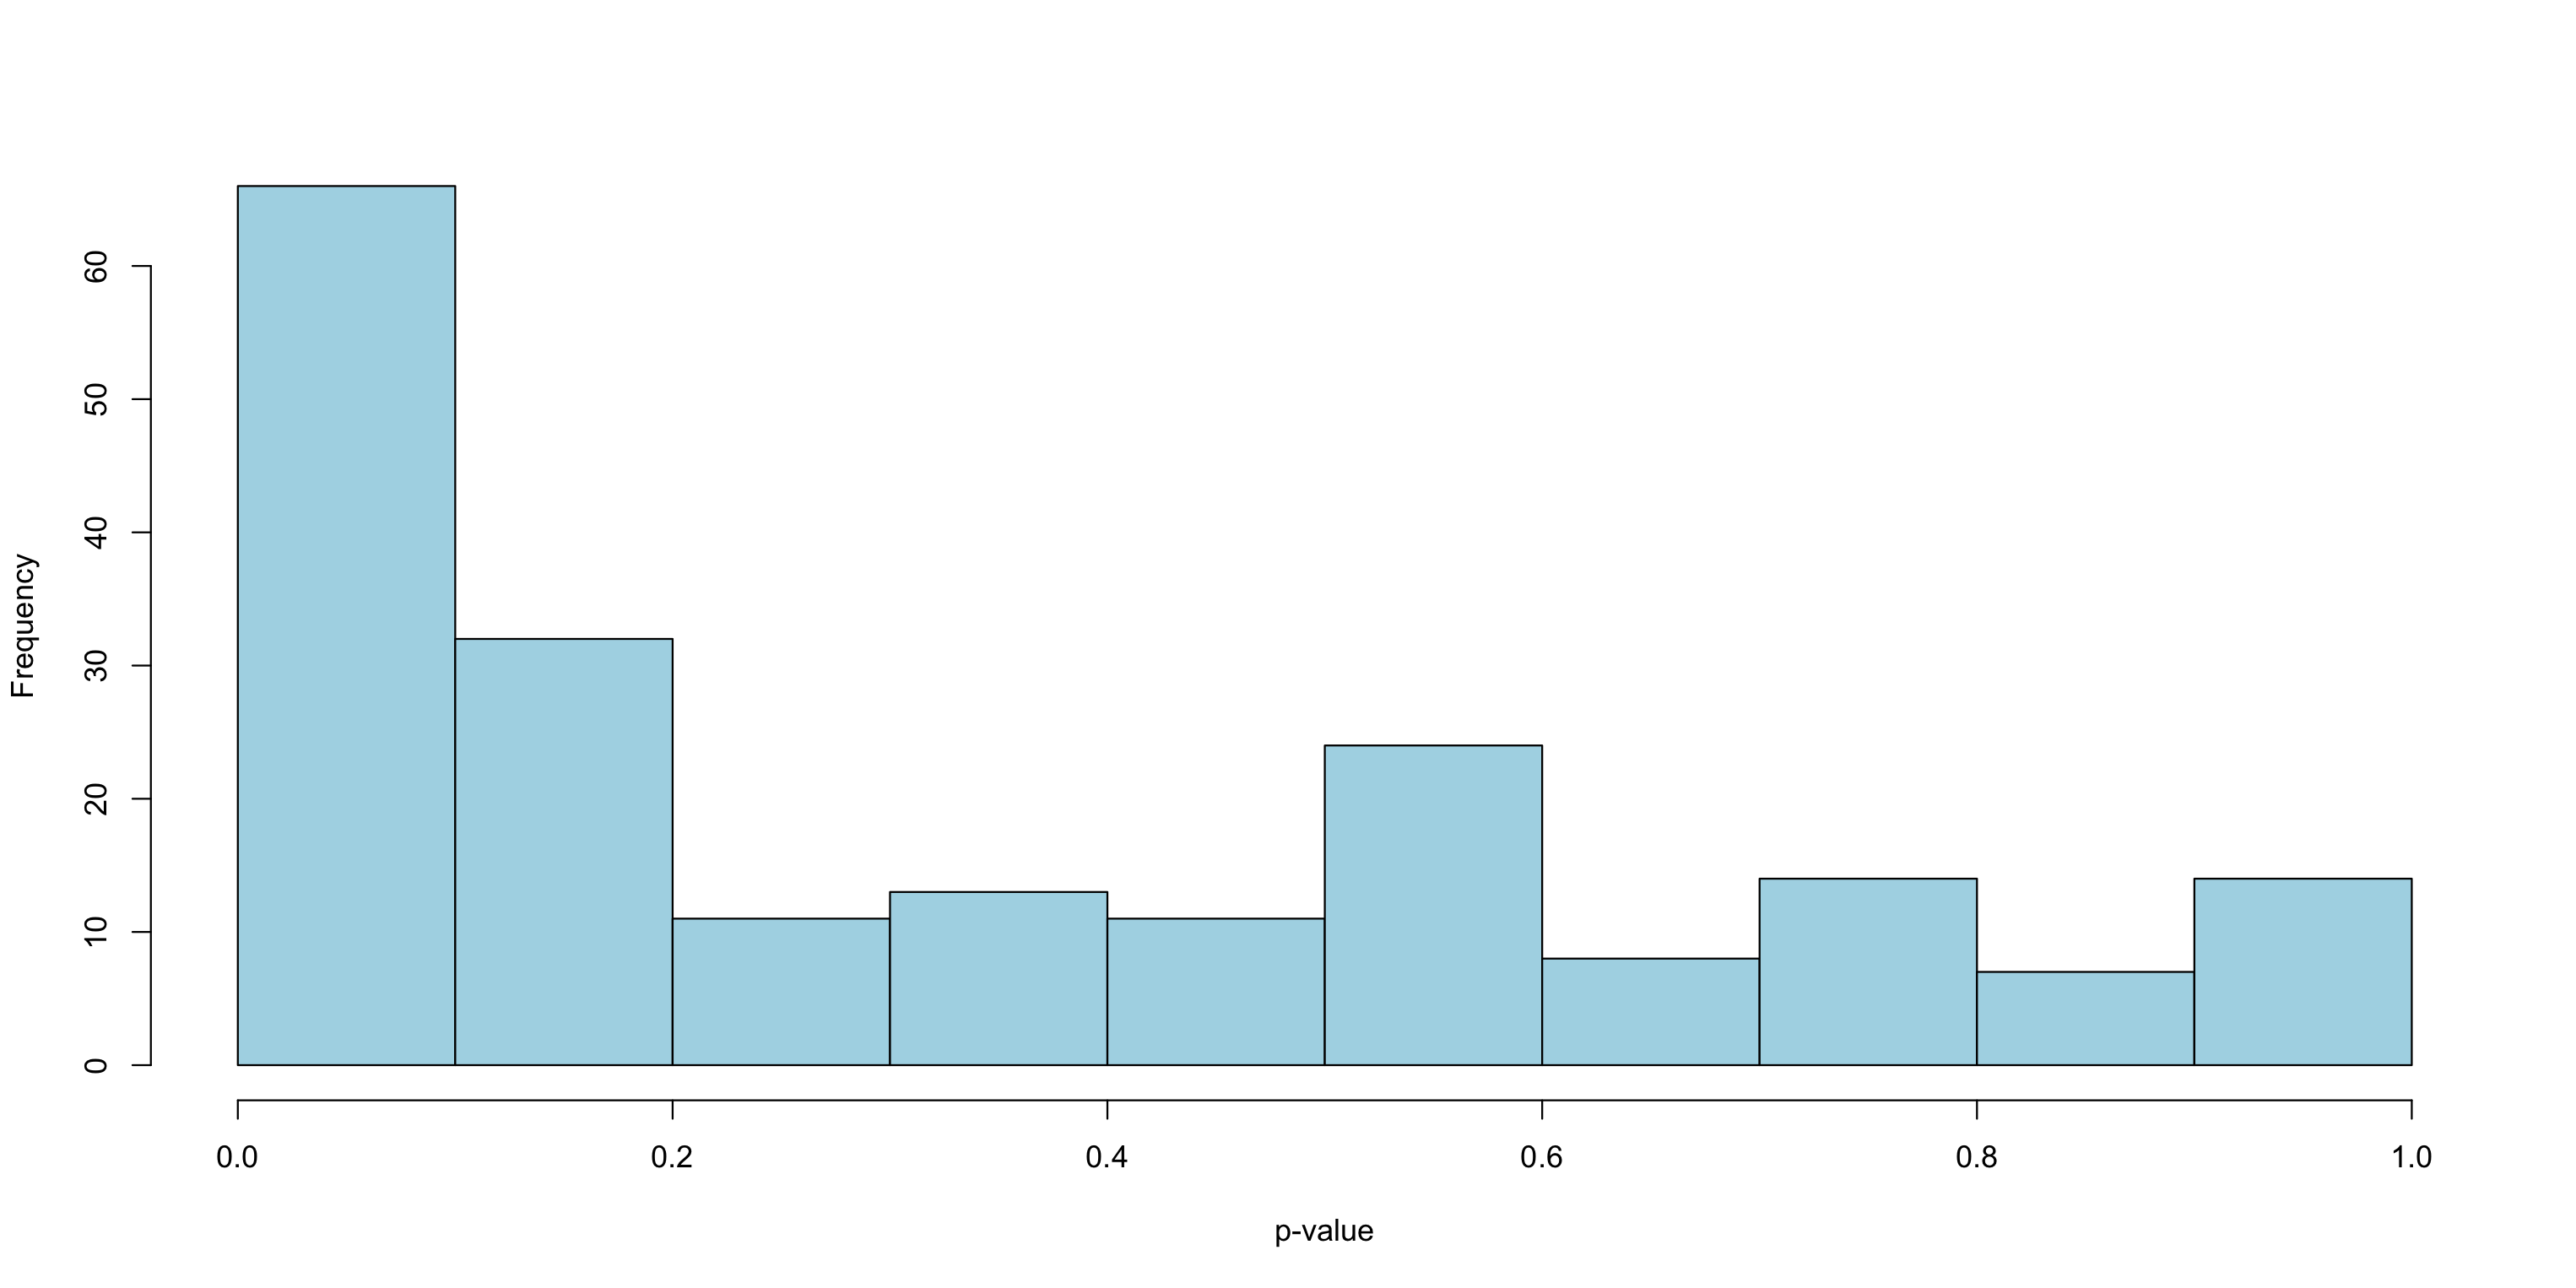

In [5]:
pvals <- summary(full)$coef[-1,4] #-1 to drop the intercept
hist(pvals, xlab="p-value", main="", col="lightblue")

Do a Benjamini-Hochberg correction with 10% FDR

[1] 0.01217043

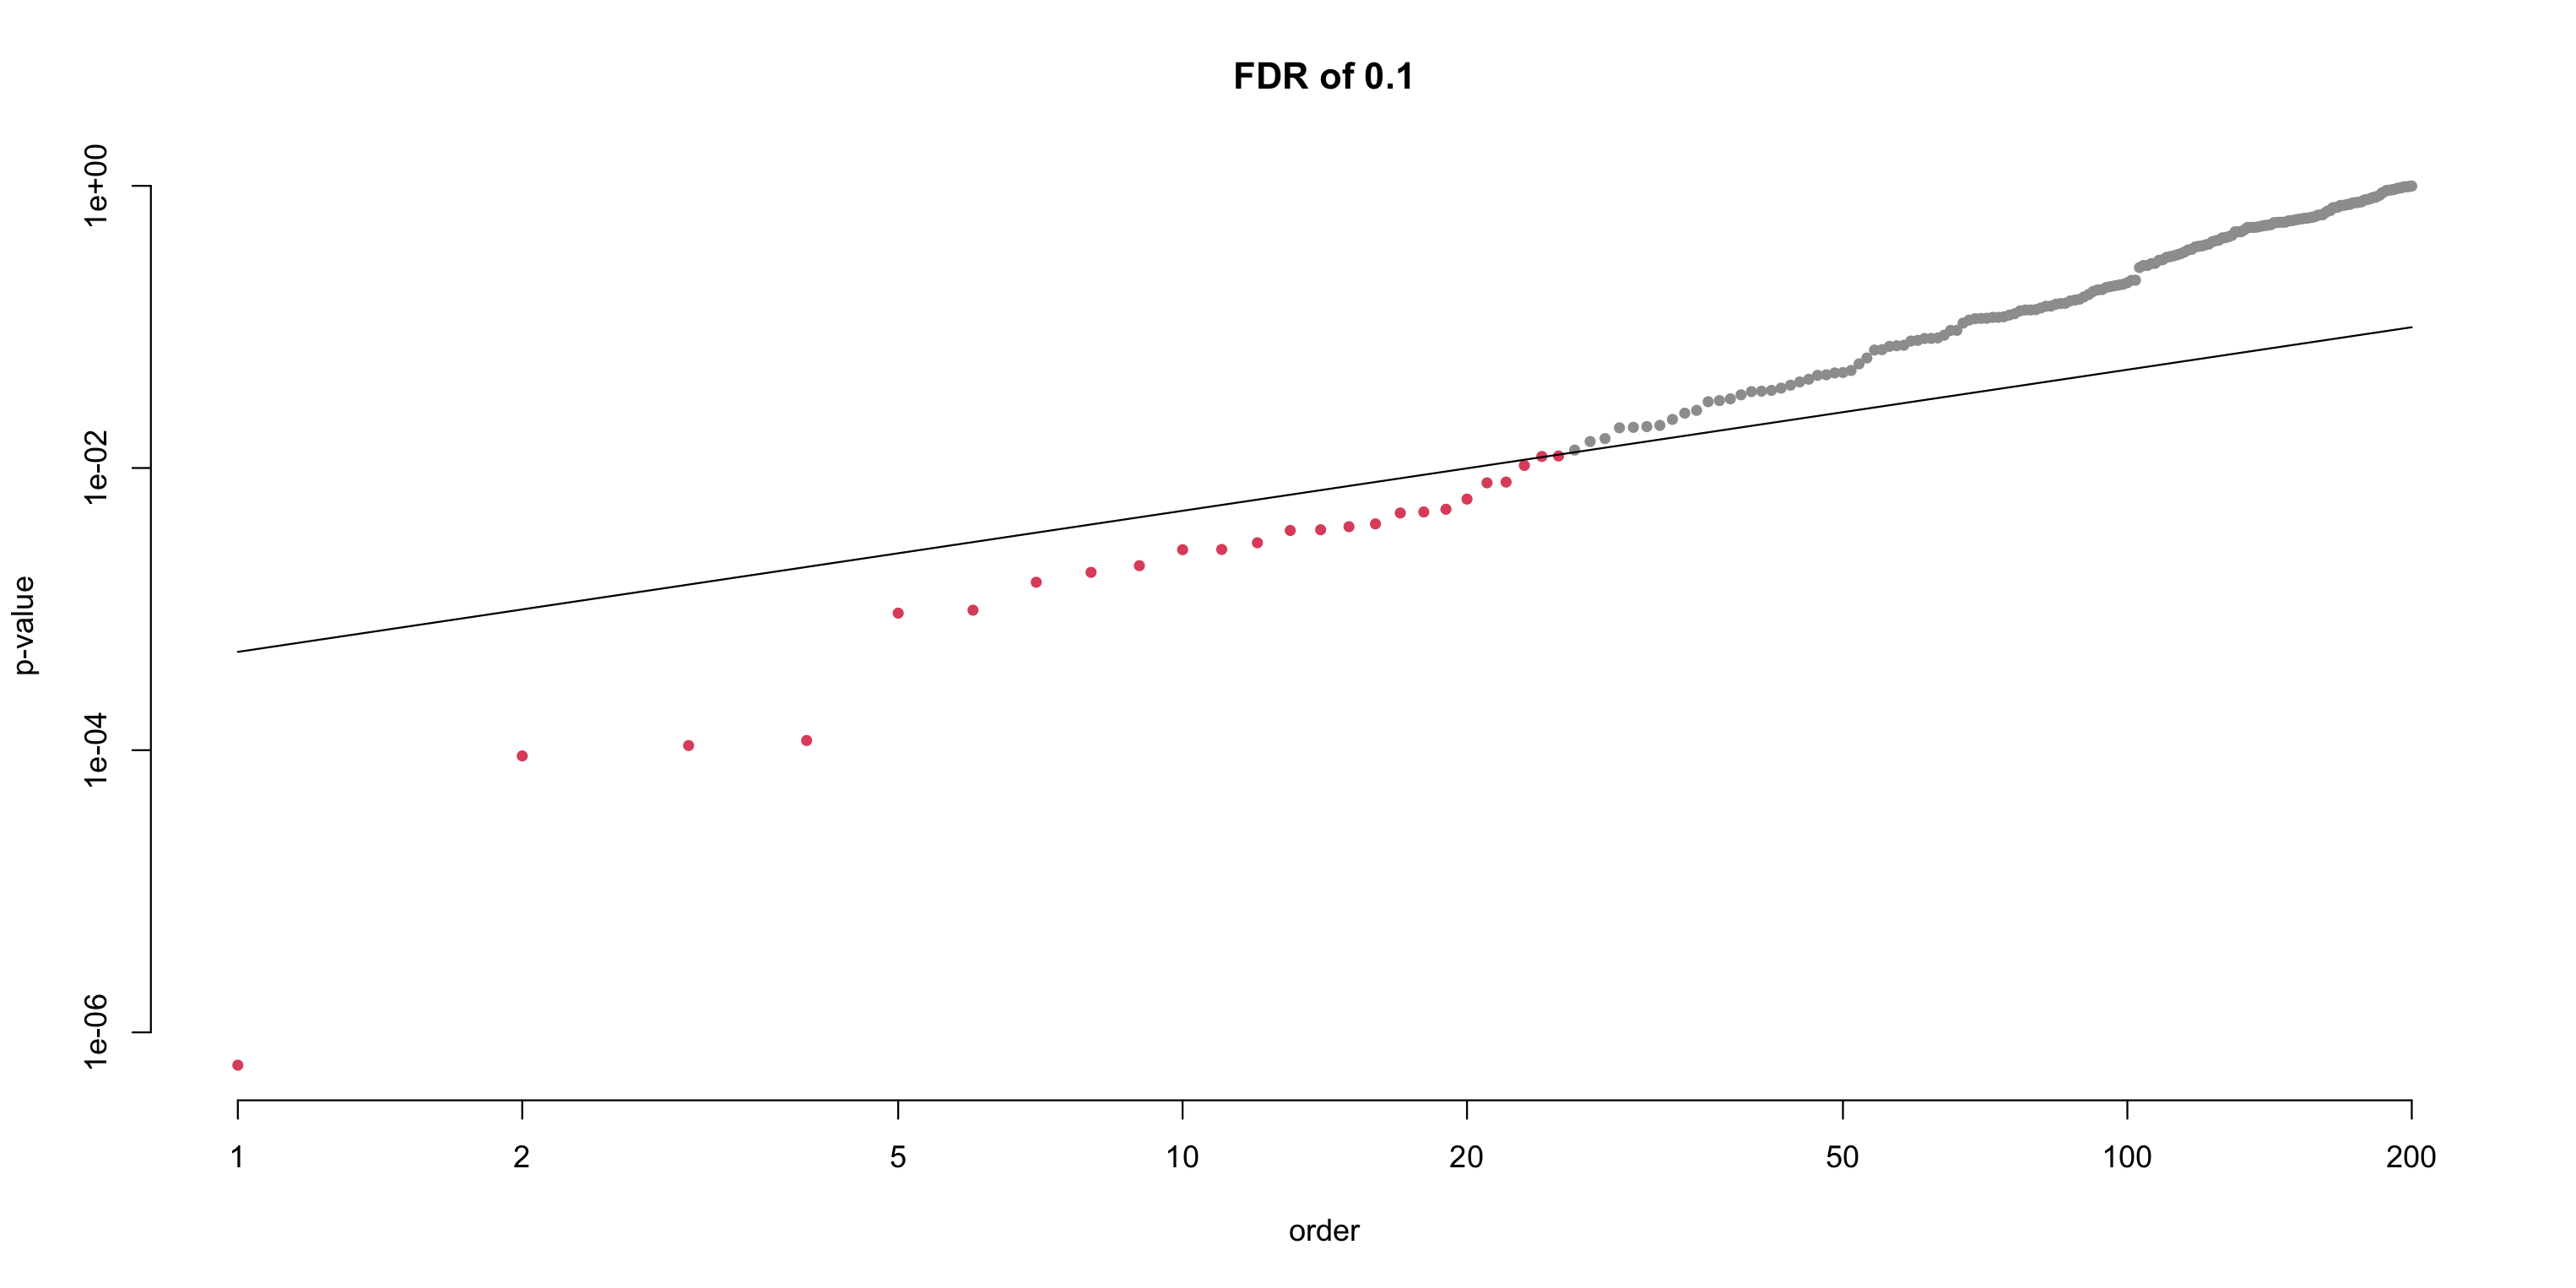

In [6]:
fdr_cut <- function(pvals, q=0.1){
  pvals <- sort(pvals[!is.na(pvals)])
  N <- length(pvals)
  k <- rank(pvals, ties.method="min")
  alpha <- max(pvals[ pvals<= (q*k/(N+1)) ])
  
  plot(pvals, log="xy", xlab="order", main=sprintf("FDR of %g",q),
   ylab="p-value", bty="n", col=c(8,2)[(pvals<=alpha) + 1], pch=20)
  lines(1:N, q*(1:N)/(N+1))

  return(alpha)
}

fdr_cut(pvals)


Using this cutoff, estimate a more parsimonious model

In [7]:
( signif <- which(pvals <= 0.0121704339598325) )
cutvar <- c("FAIL", names(signif))
cut <- glm(FAIL ~ ., data=SC[,c("FAIL", names(signif))], family="binomial")
1 - cut$deviance/cut$null.deviance # new in-sample R2

SIG2  SIG17  SIG19  SIG20  SIG22  SIG24  SIG46  SIG47  SIG49  SIG50  SIG52 
     2     17     19     20     22     24     46     47     49     50     52 
 SIG59  SIG61  SIG69 SIG102 SIG111 SIG136 SIG142 SIG154 SIG166 SIG178 SIG186 
    59     61     69    102    111    136    142    154    166    178    186 
SIG189 SIG200 
   189    200

[1] 0.1794997

Define deviance so it is not necessarily in-sample

In [8]:
deviance <- function(y, pred, family=c("gaussian","binomial")){
	family <- match.arg(family)
	if(family=="gaussian"){
		return( sum( (y-pred)^2 ) )
	}else{
		if(is.factor(y)) y <- as.numeric(y)>1
		return( -2*sum( y*log(pred) + (1-y)*log(1-pred) ) )
	}
}

For R2, also do null deviance (not necessarily in-sample)

In [9]:
R2 <- function(y, pred, family=c("gaussian","binomial")){
	fam <- match.arg(family)
	if(fam=="binomial"){
		if(is.factor(y)){ y <- as.numeric(y)>1 }
	}
	dev <- deviance(y, pred, family=fam)
	dev0 <- deviance(y, mean(y), family=fam)
	return(1-dev/dev0)
}

Set up folds

In [10]:
n <- nrow(SC) # the number of observations
K <- 10 # the number of `folds'
# create a vector of fold memberships (random order)
foldid <- rep(1:K,each=ceiling(n/K))[sample(1:n)]
# create an empty dataframe of results
OOS <- data.frame(full=rep(NA,K), cut=rep(NA,K)) 

The OOS experiment in a loop over folds

In [11]:
for(k in 1:K){ 
	train <- which(foldid!=k) # train on all but fold `k'
		
	## fit the two regressions
	rfull <- glm(FAIL~., data=SC, subset=train, family=binomial)
	rcut <- glm(FAIL~., data=SC[,cutvar], subset=train, family=binomial)

	## get predictions: type=response so we have probabilities
	predfull <- predict(rfull, newdata=SC[-train,], type="response")
	predcut <- predict(rcut, newdata=SC[-train,], type="response")

	## calculate and log R2
	OOS$full[k] <- R2(y=SC$FAIL[-train], pred=predfull, family="binomial")
	OOS$cut[k] <- R2(y=SC$FAIL[-train], pred=predcut, family="binomial")

	## print progress
	cat(k, " ")
}

Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”


1  

Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”


2  

Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”


3  

Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”


4  

Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”


5  

Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”


6  

Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”


7  

Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”


8  

Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”


9  

Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”


10  

Plotting the distribution of R2 over the folds for the two models

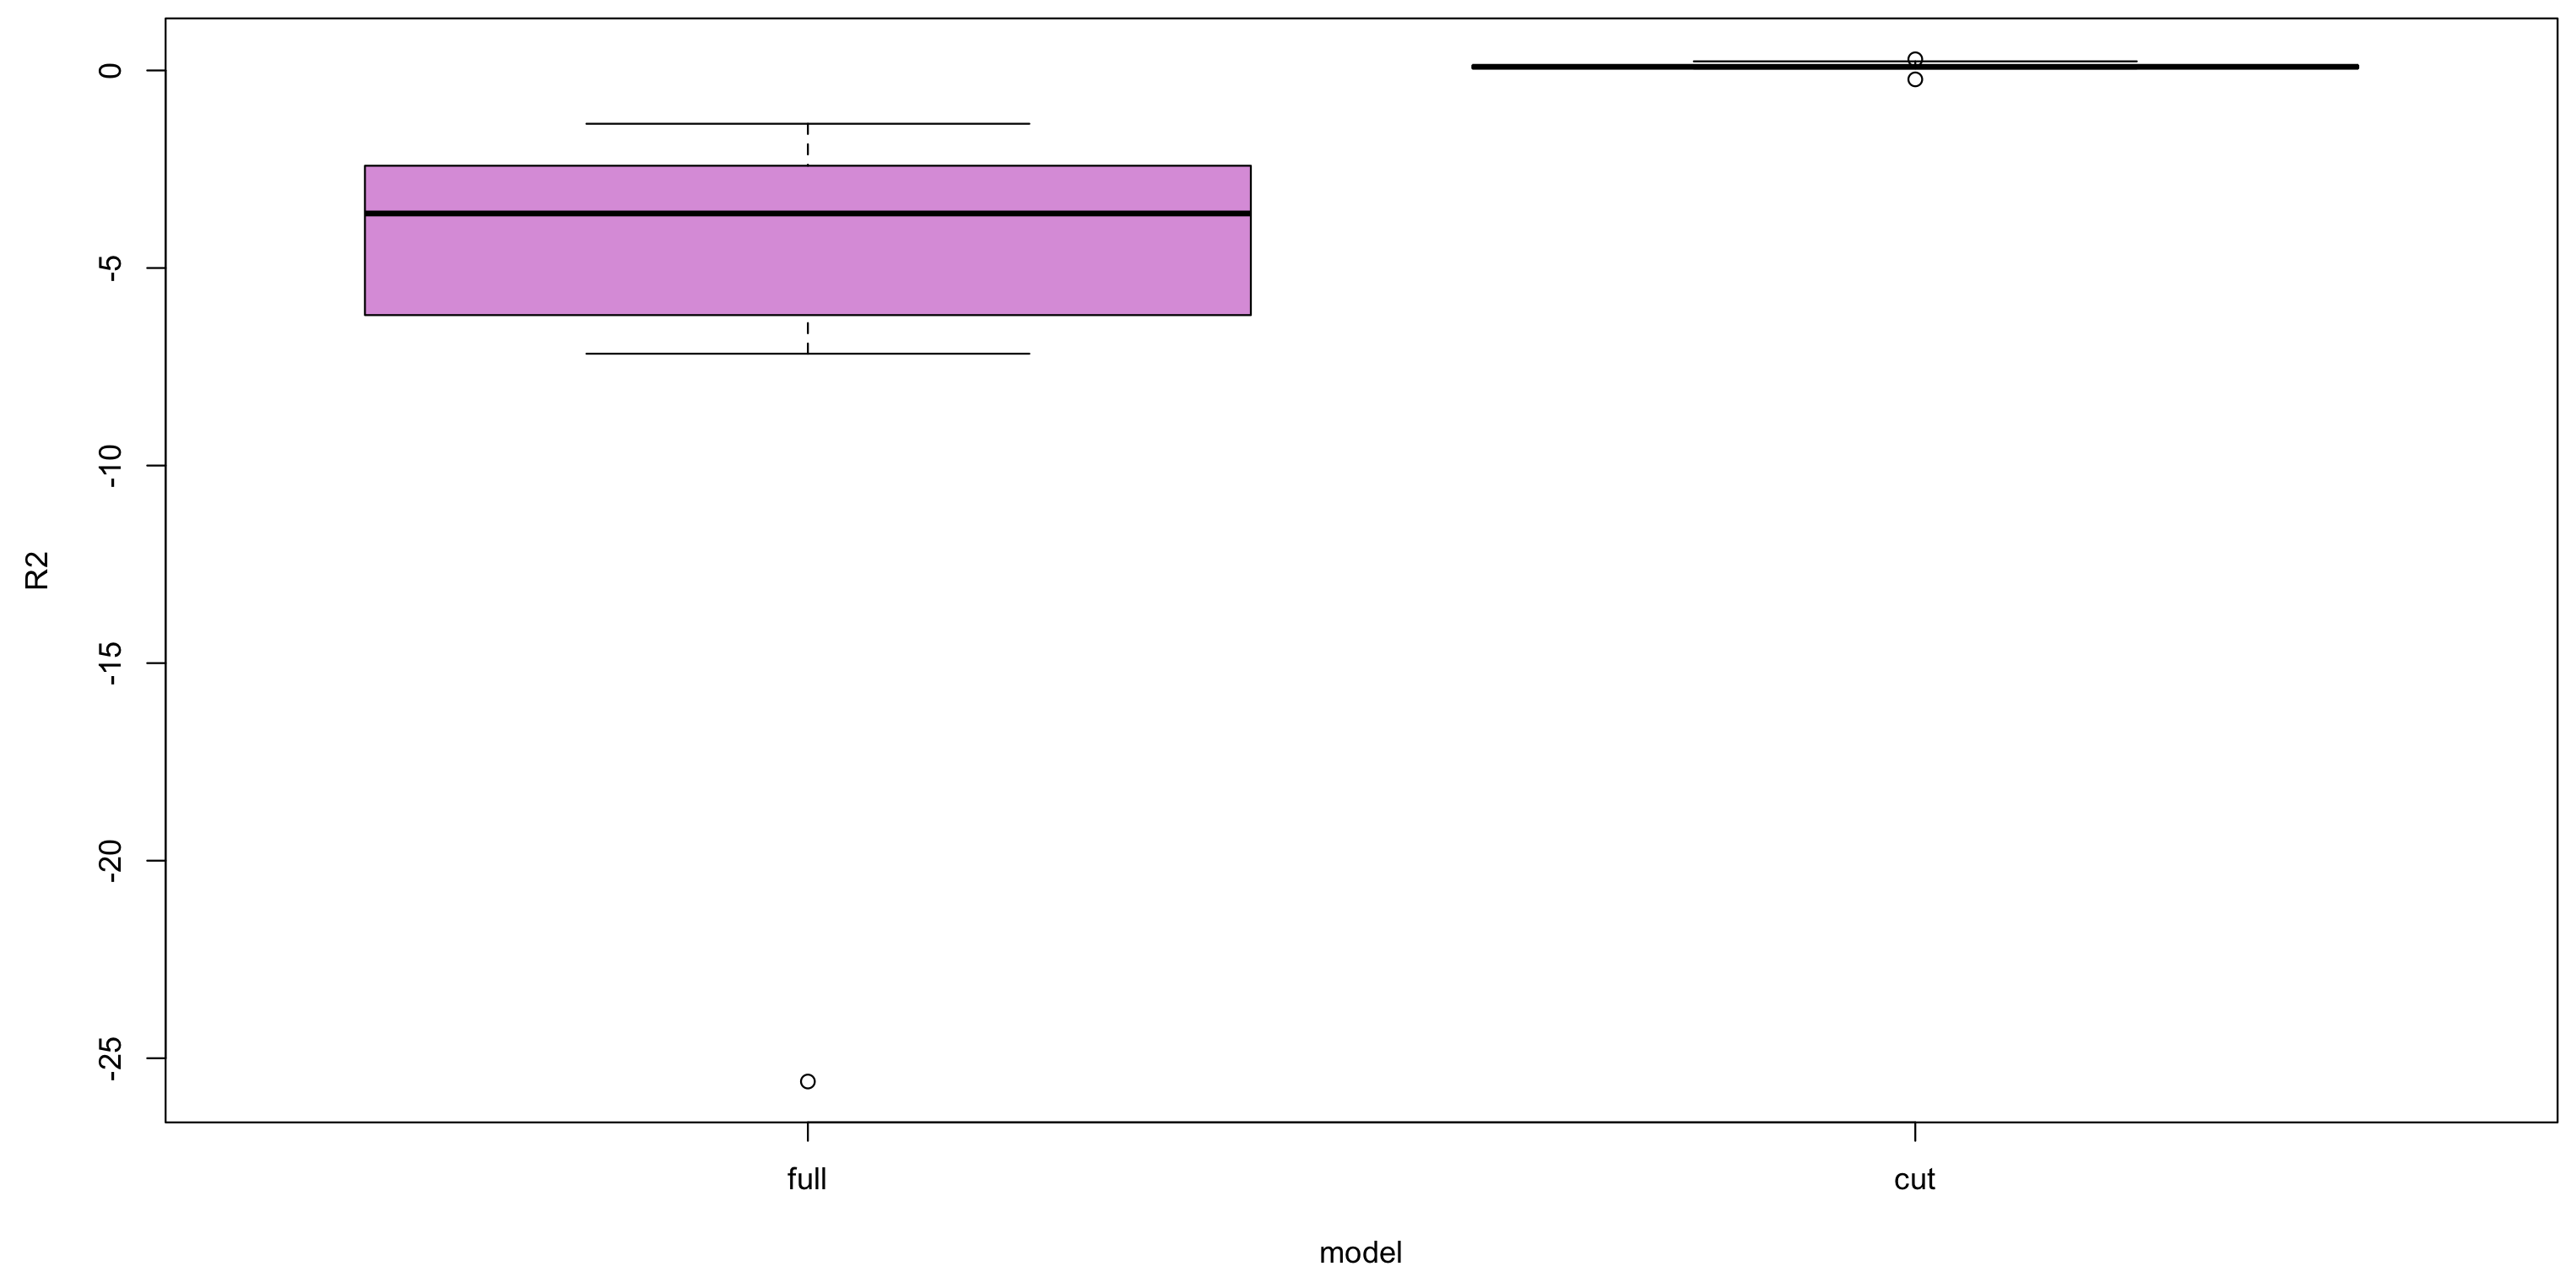

In [12]:
par(mai=c(.9,.9,.1,.1))
boxplot(OOS, col="plum", ylab="R2", xlab="model", bty="n")

Of just check average R2:

In [13]:
colMeans(OOS)

full         cut 
-6.03034907  0.08933846

## Forward stepwise

Null model:

In [14]:
null <- glm(FAIL~1, data=SC)

Stepwise, also with time elapsed logged:

In [15]:
system.time(fwd <- step(null, scope=formula(full), dir="forward"))
length(coef(fwd)) # chooses around 70 coef

Start:  AIC=115.03
FAIL ~ 1

         Df Deviance     AIC
+ SIG2    1   91.699  92.588
+ SIG189  1   92.132  99.534
+ SIG13   1   92.327 102.664
+ SIG166  1   92.406 103.923
+ SIG61   1   92.463 104.832
+ SIG173  1   92.588 106.832
+ SIG50   1   92.619 107.323
+ SIG167  1   92.743 109.302
+ SIG24   1   92.793 110.103
+ SIG18   1   92.813 110.419
+ SIG154  1   92.830 110.685
+ SIG178  1   92.893 111.690
+ SIG57   1   92.897 111.761
+ SIG136  1   92.918 112.094
+ SIG7    1   92.934 112.344
+ SIG117  1   92.934 112.345
+ SIG147  1   92.937 112.387
+ SIG104  1   92.948 112.564
+ SIG153  1   92.971 112.926
+ SIG193  1   92.973 112.959
+ SIG97   1   92.977 113.029
+ SIG99   1   92.978 113.042
+ SIG42   1   92.983 113.125
+ SIG175  1   92.994 113.293
+ SIG142  1   92.997 113.347
+ SIG133  1   92.998 113.360
+ SIG155  1   93.016 113.644
+ SIG111  1   93.022 113.735
+ SIG169  1   93.023 113.762
+ SIG134  1   93.030 113.867
+ SIG16   1   93.036 113.968
+ SIG27   1   93.037 113.971
+ SIG80   1   

   user  system elapsed 
 75.984   1.486 156.811 

[1] 69

Use Taddy's library for LASSO

In [16]:
install.packages("gamlr")
library(gamlr)


The downloaded binary packages are in
	/var/folders/dk/2_0472cd7h35shgpvb9y6g6xp8980h/T//RtmprBsVEf/downloaded_packages


Loading required package: Matrix



Note we'll need to define our own design matrices here. This is extra work, but worth it because sparse matrices are way more efficient for many cases, and specifically, the data often comes in triplets exactly like here:

In [17]:
scx <- sparse.model.matrix(FAIL ~ ., data=SC)[,-1]

After our X matrix, it is often also convenient to have the outcome y as a vector of its own:

In [18]:
scy <- SC$FAIL

Fitting a LASSO, and having a look at the path:

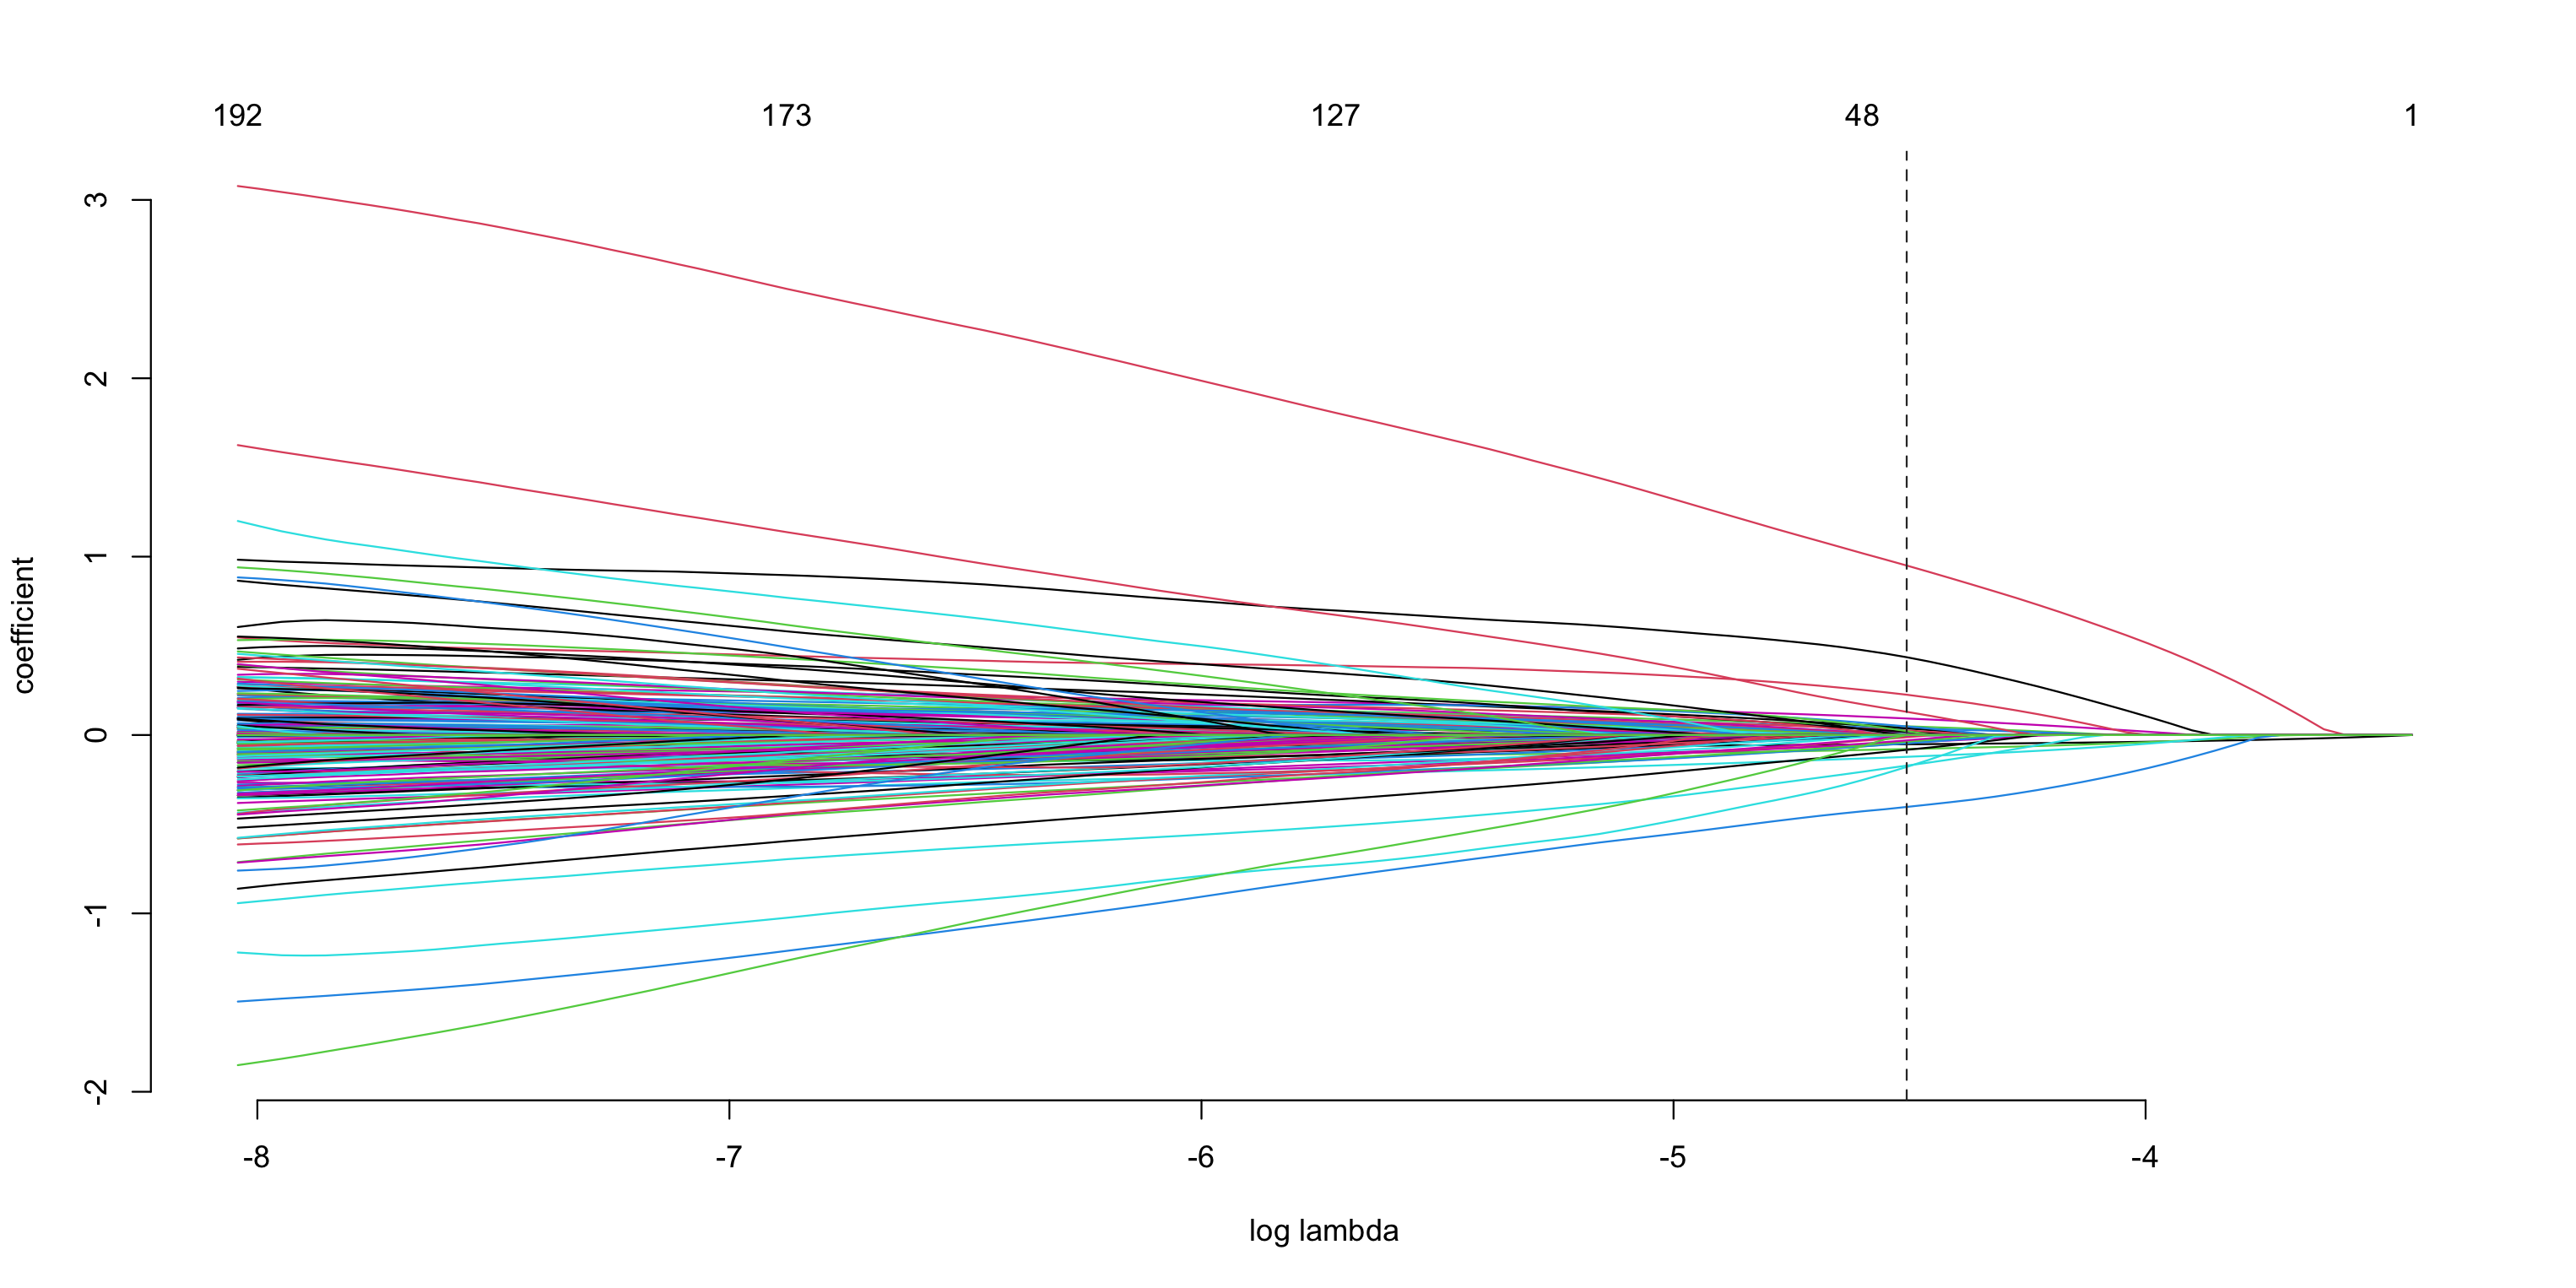

In [19]:
sclasso <- gamlr(scx, scy, family="binomial")
plot(sclasso) # the ubiquitous path plot

Note that this plot is not in the book, by then we switched to browser data!
Let's finish up with the semiconductor example first before we follow the book along.

One (fast) way to pick a lambda: the AICc parameter

In [20]:
scbeta <- coef(sclasso) 
log(sclasso$lambda[which.min(AICc(sclasso))])
sum(scbeta!=0) # chooses 30 (+intercept) @ log(lambda) = -4.5

seg24 
-4.50608

[1] 31

See how conservative the BIC can get:

In [21]:
BICseg <- which.min(BIC(sclasso))
scb.bic <- coef(sclasso, s=BICseg)
sum(scb.bic!=0) 

[1] 1

We are just left with the intercept!

Of course, we just learned about the wonderful principle of cross-validation, so let's try that too:

fold 1,2,3,4,5,done.


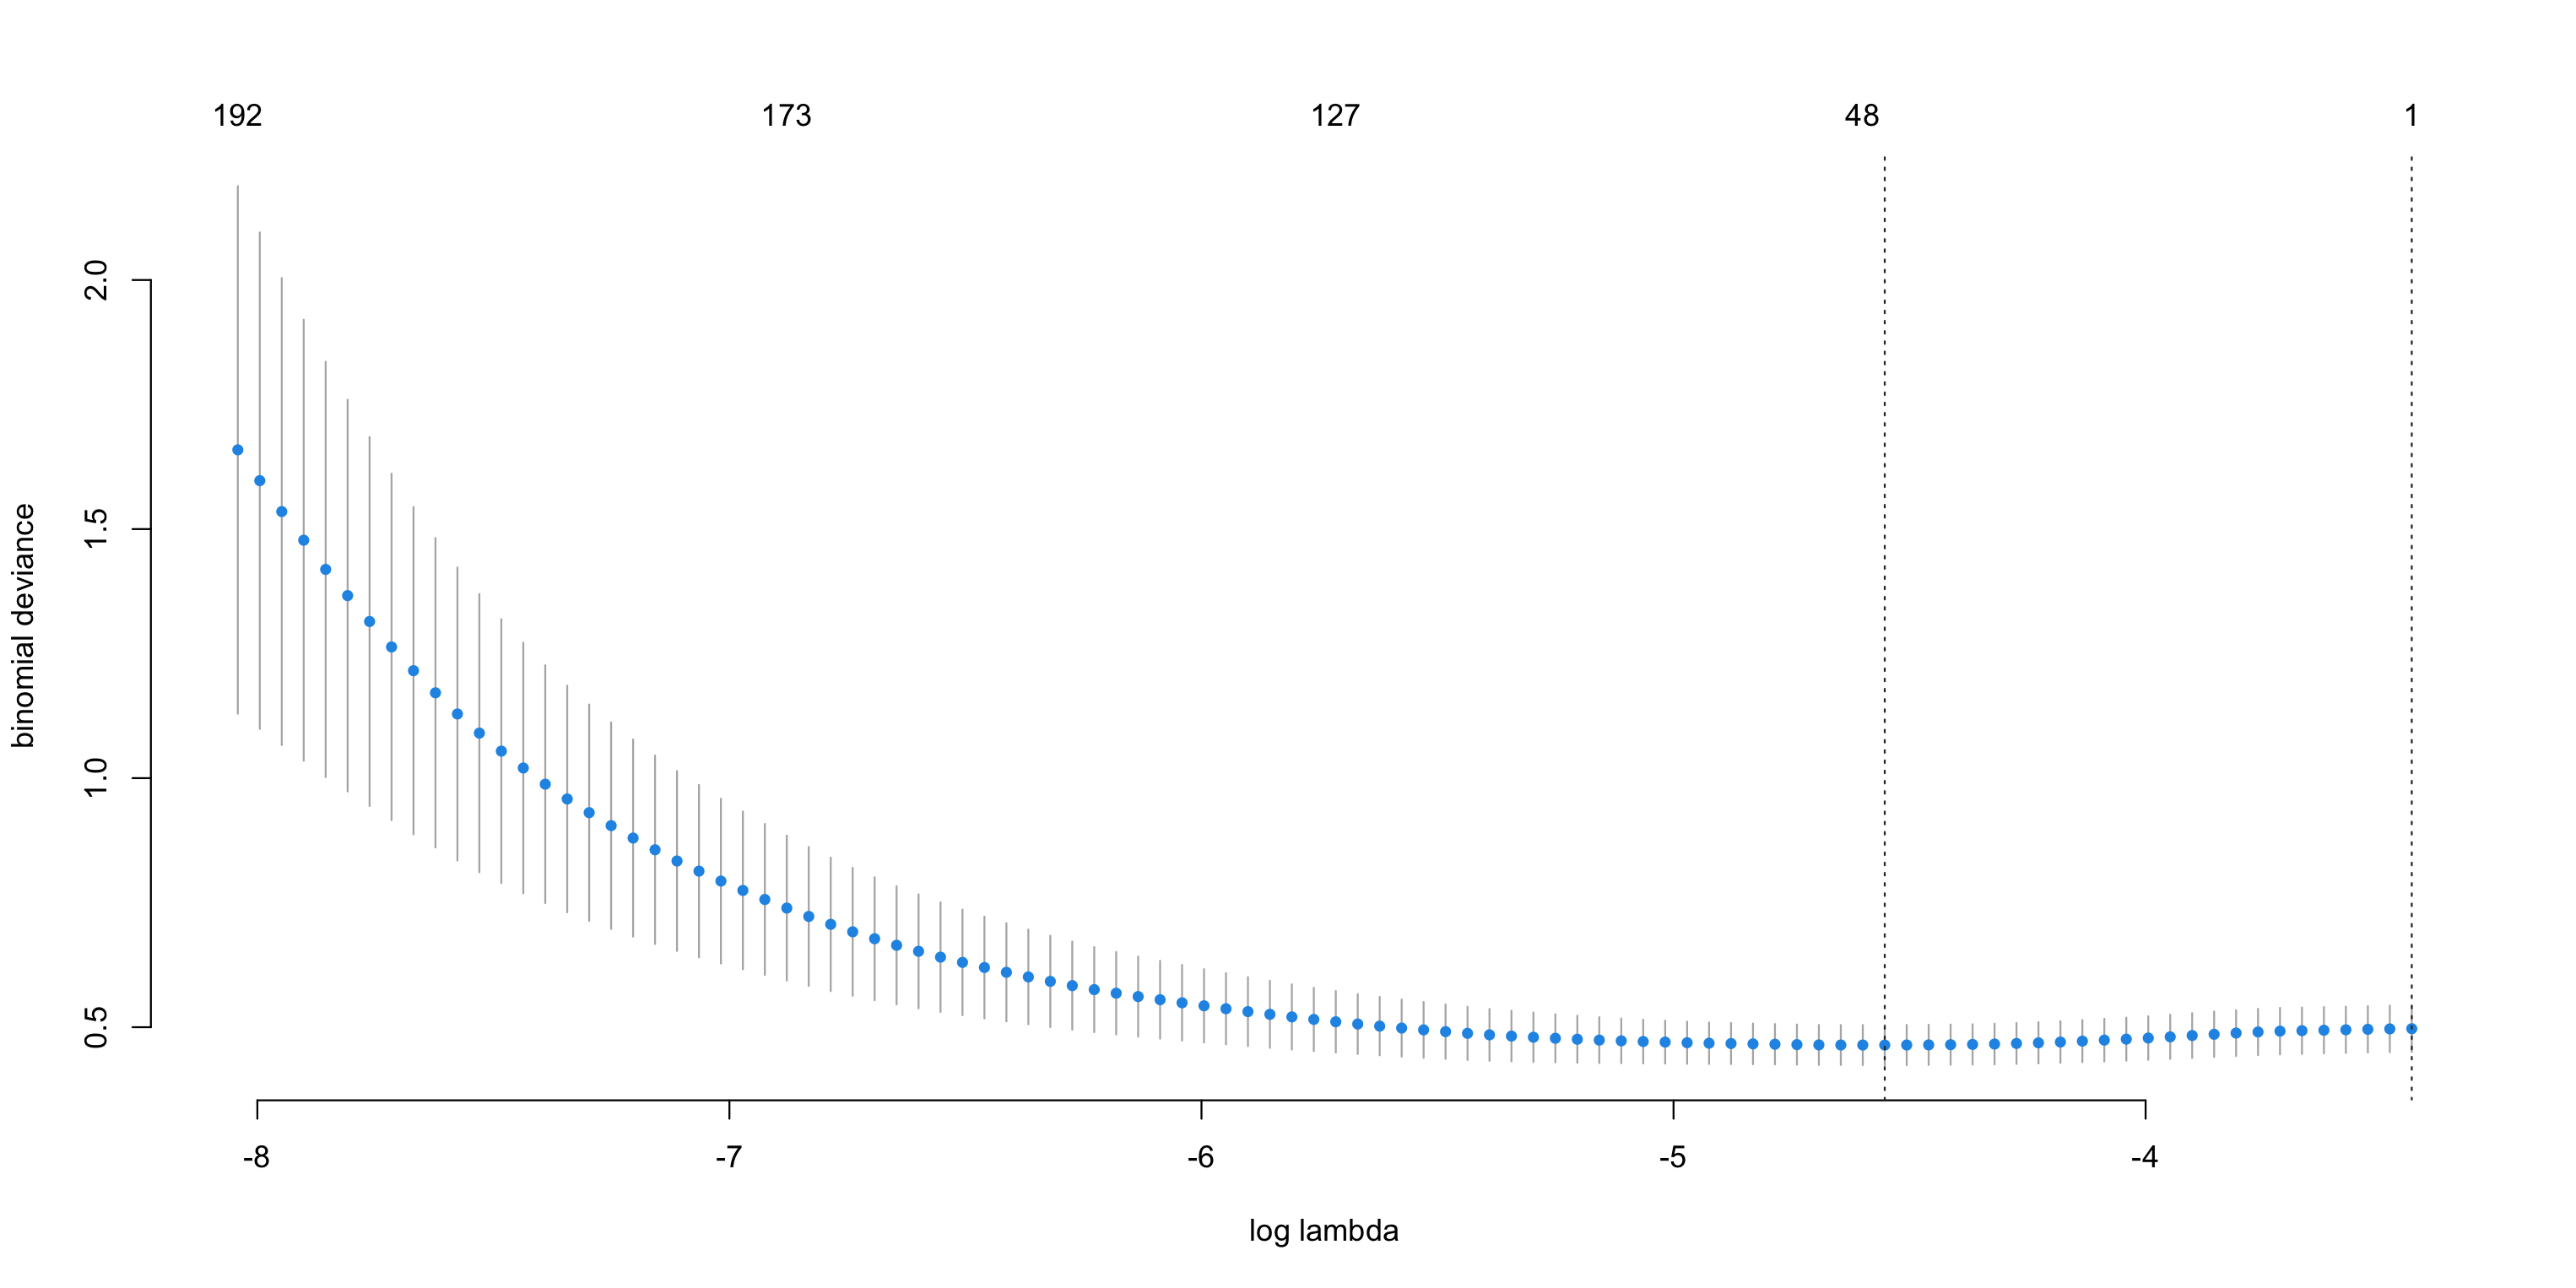

In [22]:
sccvl <- cv.gamlr(scx, scy, family="binomial", verb=TRUE)
plot(sccvl, bty="n")

Let's select the lambda that minimizes deviance here:

In [23]:
scb.min <- coef(sccvl, select="min")
log(sccvl$lambda.min)
sum(scb.min!=0)

[1] -4.552597

[1] 40

Note that I got a different answer than Taddy here. There is Monte Carlo uncertainty/noise in the cross-validation, in the sense that the exact cuts are random, i.e. which observation goes into which fold. As the deviance was pretty flat around the minimal lambda, even some small noise could mean that we got a log lambda of 5, not 4.8. That also means more coefficients.

If we go with the default of the gamlr package, which wanted to respect the default in the glmnet package, you get the biggest lambda (smallest in absolute value) with average out-of-sample deviance no more than one standard deviation away from the minimum.

In [24]:
scb.1se <- coef(sccvl)
log(sccvl$lambda.1se)
sum(scb.1se!=0)

[1] -3.436192

[1] 1

Again, this lambda is conservative enough, that you're left with only the intercept in the model.

Luckily, we also collected the information criteria for all the models we ran for all these possible lambdas, and we can check Taddy's promise that AICc is close to the cross-validated deviance, at least where it matters (around the minimum):

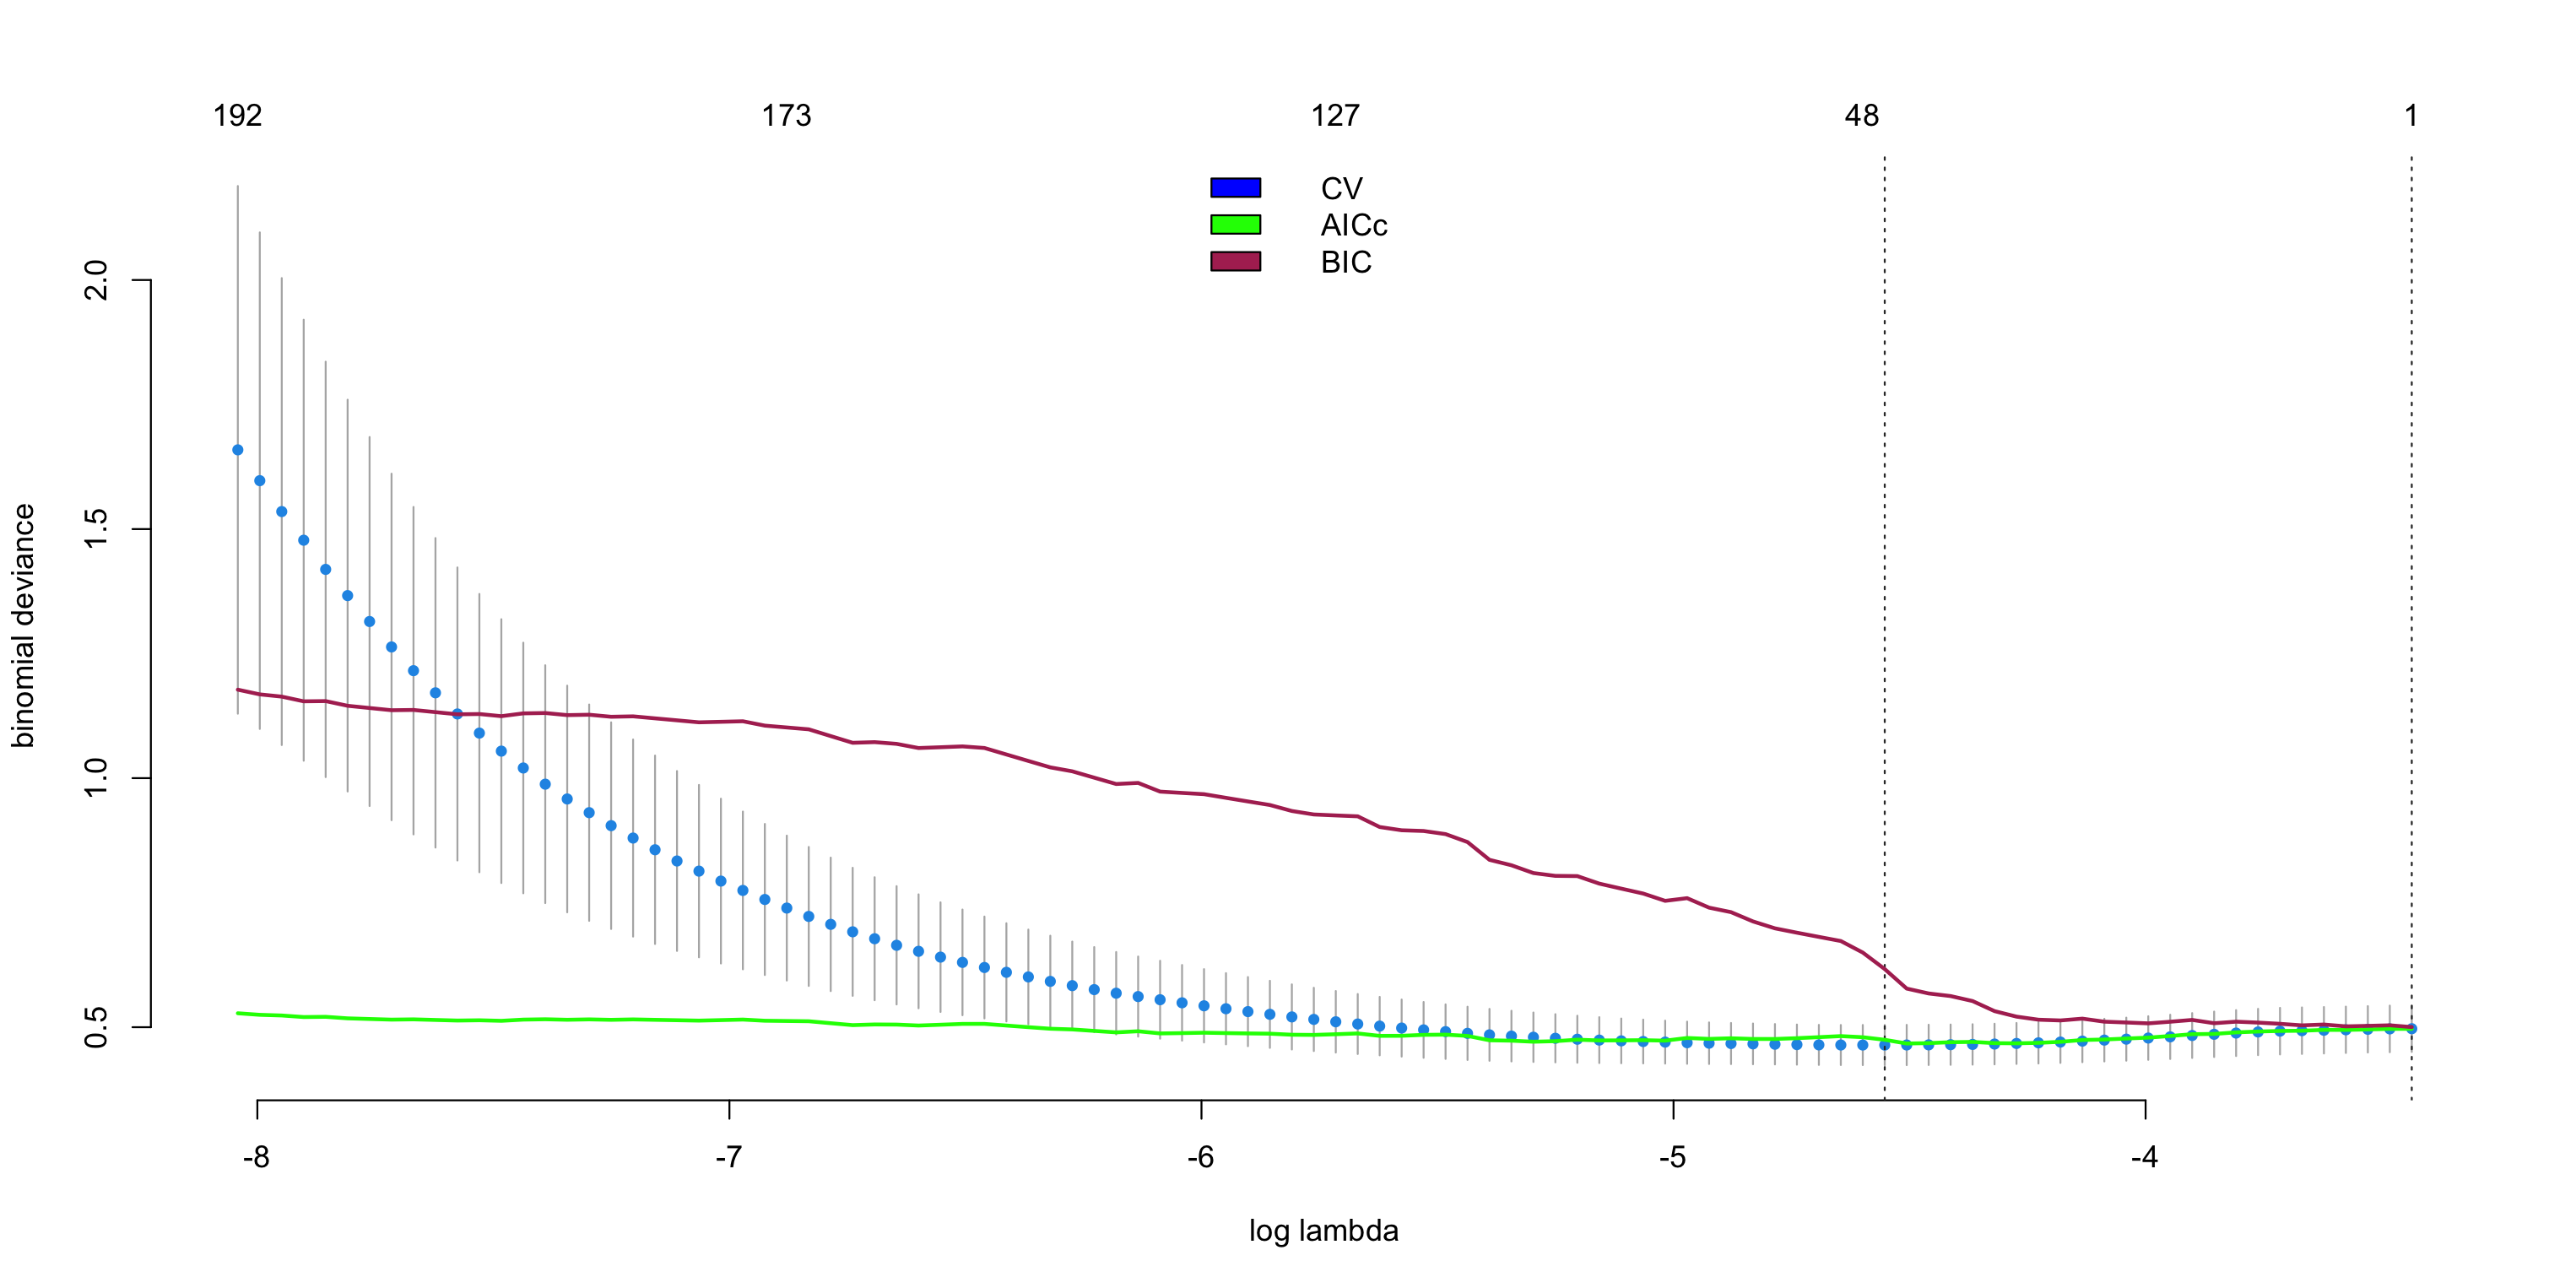

In [25]:
plot(sccvl, bty="n")
lines(log(sclasso$lambda),AICc(sclasso)/n, col="green", lwd=2)
lines(log(sclasso$lambda),BIC(sclasso)/n, col="maroon", lwd=2)
legend("top", fill=c("blue","green","maroon"),
	legend=c("CV","AICc","BIC"), bty="n")

We can just check quickly the information criteria for the two models we considered originally, motivated by a Benjamini-Hochberg FDR cut:

In [26]:
BIC(full)
BIC(cut)

AIC(full)
AIC(cut)

AICc(full)
AICc(cut)

[1] 1787.184

[1] 782.7148

[1] 722.3321

[1] 650.2706

[1] 786.0215

[1] 651.1665

Note that the cut model has 25 variables. For the lasso, some of these criteria suggested to keep only the intercept, or have 30 variables. But none of them would prefer the full model to the cut model.

## Lasso in the browser data

First let's setup the browser and spending datasets. The browsing history table has three colums: [machine] id, site [id], [# of] visits

In [27]:
web <- read.csv("browser-domains.csv")

Read in the actual website names and relabel site factor and also factor machine id.

In [28]:
sitenames <- scan("browser-sites.txt", what="character")
web$site <- factor(web$site, levels=1:length(sitenames), labels=sitenames)
web$id <- factor(web$id, levels=1:length(unique(web$id)))

Calculate total visits per machine and percent of time on each site.
The handy function tapply(a,b,c) does c(a) for every level of factor b.

In [29]:
machinetotals <- as.vector(tapply(web$visits,web$id,sum)) 
visitpercent <- 100*web$visits/machinetotals[web$id]

This goes into a sparse matrix. (Try to pick this up, this is very useful.)

In [30]:
xweb <- sparseMatrix(
	i=as.numeric(web$id), j=as.numeric(web$site), x=visitpercent,
	dims=c(nlevels(web$id),nlevels(web$site)),
	dimnames=list(id=levels(web$id), site=levels(web$site)))

As a sanity check, see what sites household #1 visited

In [31]:
head(xweb[1, xweb[1,]!=0])

atdmt.com          yahoo.com            msn.com         google.com 
         4.0520260         11.8559280          0.2501251          6.5282641 
           aol.com questionmarket.com 
         0.1500750          1.3506753

Read in the spending data, with the first column as the (here: trivial) names for the rows. Also transform it immediately to matrix.

In [32]:
yspend <- read.csv("browser-totalspend.csv", row.names=1)
yspend <- as.matrix(yspend)

Run my lasso models with different penalty parameters (lambda), and plot this path.

In [ ]:
spender <- gamlr(xweb, log(yspend), verb=TRUE)
plot(spender)

*** n=10000 observations and p=1000 covariates ***
segment 1: lambda = 0.2325, dev = 2.783e+04, npass = 0
segment 2: lambda = 0.2219, dev = 2.778e+04, npass = 3
segment 3: lambda = 0.2118, dev = 2.774e+04, npass = 3
segment 4: lambda = 0.2022, dev = 2.77e+04, npass = 3
segment 5: lambda = 0.193, dev = 2.766e+04, npass = 3
segment 6: lambda = 0.1842, dev = 2.76e+04, npass = 3
segment 7: lambda = 0.1759, dev = 2.753e+04, npass = 4
segment 8: lambda = 0.1679, dev = 2.744e+04, npass = 5
segment 9: lambda = 0.1602, dev = 2.733e+04, npass = 5
segment 10: lambda = 0.153, dev = 2.72e+04, npass = 5
segment 11: lambda = 0.146, dev = 2.708e+04, npass = 5
segment 12: lambda = 0.1394, dev = 2.697e+04, npass = 5
segment 13: lambda = 0.133, dev = 2.687e+04, npass = 5
segment 14: lambda = 0.127, dev = 2.676e+04, npass = 5
segment 15: lambda = 0.1212, dev = 2.663e+04, npass = 5
segment 16: lambda = 0.1157, dev = 2.65e+04, npass = 5
segment 17: lambda = 0.1104, dev = 2.639e+04, npass = 5
segment 18: lam

We can also run many regressions stepwise and plot coefficients analogously.

In [34]:
stepspend <- gamlr(xweb, log(yspend), verb=TRUE, gamma=Inf, lmr=.1)
par(mai=c(.9,.9,.1,.1))
plot(stepspend, df=FALSE, select=FALSE)

*** n=10000 observations and p=1000 covariates ***
segment 1: lambda = 0.2325, dev = 2.783e+04, npass = 0
segment 2: lambda = 0.2271, dev = 2.78e+04, npass = 3
segment 3: lambda = 0.2219, dev = 2.729e+04, npass = 3
segment 4: lambda = 0.2168, dev = 2.729e+04, npass = 1
segment 5: lambda = 0.2118, dev = 2.729e+04, npass = 1
segment 6: lambda = 0.207, dev = 2.729e+04, npass = 1
segment 7: lambda = 0.2022, dev = 2.729e+04, npass = 1
segment 8: lambda = 0.1975, dev = 2.729e+04, npass = 1
segment 9: lambda = 0.193, dev = 2.729e+04, npass = 1
segment 10: lambda = 0.1886, dev = 2.729e+04, npass = 1
segment 11: lambda = 0.1842, dev = 2.729e+04, npass = 1
segment 12: lambda = 0.18, dev = 2.728e+04, npass = 3
segment 13: lambda = 0.1759, dev = 2.696e+04, npass = 4
segment 14: lambda = 0.1718, dev = 2.696e+04, npass = 1
segment 15: lambda = 0.1679, dev = 2.666e+04, npass = 4
segment 16: lambda = 0.164, dev = 2.666e+04, npass = 1
segment 17: lambda = 0.1602, dev = 2.666e+04, npass = 1
segment 18: 

Notice that the stepwise coefficients jump around (as you go from right to left and more and more variables are added to your model). This is why this method is very fragile. The lasso plot above is much smoother.

So go back to that, and check the coefficients it would select (by default, it will give you the model picked by the AICc criterion). You can drop the intercept and check which websites predict low and high spending:

In [35]:
B <- coef(spender)
B <- B[-1,]
B[which.min(B)]
B[which.max(B)]

cursormania.com 
      -0.998143

shopyourbargain.com 
           1.294246

We can repeat the same exercise with Bayes's Information Criterion.

In [36]:
coef(spender, select=which.min(BIC(spender)))

1001 x 1 sparse Matrix of class "dgCMatrix"
                                      seg31
intercept                       5.929791309
atdmt.com                       .          
yahoo.com                       .          
whenu.com                       .          
weatherbug.com                  .          
msn.com                         .          
google.com                      .          
aol.com                         .          
questionmarket.com              0.013756425
googlesyndication.com-o02       .          
casalemedia.com                 .          
mywebsearch.com                 .          
myspace.com                     .          
pointroll.com                   .          
atwola.com                      .          
yieldmanager.com                .          
live.com                        .          
aim.com                         .          
mediaplex.com                   .          
precisionclick.com              .          
tribalfusion.com                

Or eyeball the AIC criteria for the various models:

In [37]:
AIC(spender)

seg1      seg2      seg3      seg4      seg5      seg6      seg7      seg8 
10236.678 10221.410 10205.650 10191.269 10178.147 10159.757 10136.497 10107.909 
     seg9     seg10     seg11     seg12     seg13     seg14     seg15     seg16 
10072.514 10028.411  9986.667  9945.585  9908.785  9873.471  9829.169  9782.728 
    seg17     seg18     seg19     seg20     seg21     seg22     seg23     seg24 
 9740.226  9703.940  9661.842  9624.061  9584.790  9551.020  9517.208  9477.321 
    seg25     seg26     seg27     seg28     seg29     seg30     seg31     seg32 
 9447.791  9412.077  9375.161  9349.058  9315.922  9274.982  9242.221  9211.888 
    seg33     seg34     seg35     seg36     seg37     seg38     seg39     seg40 
 9179.433  9159.195  9131.739  9097.187  9068.182  9036.084  9005.602  8976.581 
    seg41     seg42     seg43     seg44     seg45     seg46     seg47     seg48 
 8949.770  8933.620  8905.678  8875.508  8855.903  8838.812  8821.155  8803.886 
    seg49     seg50     seg51     seg52     seg53     seg54     seg55     seg56 
 8790.893  8790.032  8776.227  8761.745  8768.031  8764.390  8763.192  8760.209 
    seg57     seg58     seg59     seg60     seg61     seg62     seg63     seg64 
 8759.604  8759.905  8754.805  8762.727  8761.390  8751.363  8760.789  8759.341 
    seg65     seg66     seg67     seg68     seg69     seg70     seg71     seg72 
 8770.654  8774.578  8777.312  8779.044  8771.709  8784.514  8789.981  8796.804 
    seg73     seg74     seg75     seg76     seg77     seg78     seg79     seg80 
 8800.761  8811.892  8827.856  8840.341  8863.466  8863.419  8879.681  8890.350 
    seg81     seg82     seg83     seg84     seg85     seg86     seg87     seg88 
 8903.339  8917.422  8926.263  8927.856  8934.396  8939.748  8947.837  8964.441 
    seg89     seg90     seg91     seg92     seg93     seg94     seg95     seg96 
 8981.560  8999.054  9018.848  9029.080  9043.901  9050.897  9050.338  9066.141 
    seg97     seg98     seg99    seg100 
 9076.301  9083.091  9102.082  9109.330

You can again do cross-validation to select a model along the lasso path. By default, the package would use the 1se rule again, but you can again just go for the minimum.

Let's compare how to website's coefficients change across the models favored by different criteria. (Not surprisingly, 1se is more conservative with fewer variables included.)

In [38]:
cv.spender <- cv.gamlr(xweb, log(yspend), verb=TRUE)
beta1se <- coef(cv.spender)
betamin <- coef(cv.spender, select="min")
cbind(beta1se,betamin)[c("tvguide.com","americanexpress.com"),]

fold 1,2,3,4,5,done.


2 x 2 sparse Matrix of class "dgCMatrix"
                          seg29      seg48
tvguide.com         .           .         
americanexpress.com 0.009602647 0.04897335

You collect the deviance and the coefficients across these models (over a range of lambdas) next to each other.

In [ ]:
par(mfrow=c(1,2))
plot(cv.spender)
plot(cv.spender$gamlr)

We can check which lambdas do the various criteria prefer:

As the chapter "promised," 1SE is conservative, but not as much as BIC, and AICc is close to deviance-minimizing value in cross-validation.

In [40]:
log(spender$lambda[which.min(AICc(spender))])
log(spender$lambda[which.min(AIC(spender))])
log(spender$lambda[which.min(BIC(spender))])
log(cv.spender$lambda.min)
log(cv.spender$lambda.1se)

seg52 
-3.831328

seg62 
-4.296497

seg31 
-2.854474

[1] -3.645261

[1] -2.76144

We can also plot the deviance and the values of various information criteria over these models (which all differ by their lambda). To put both on the same scale, we should divide the criteria by the number of observations.
Try reversing engineering which lines added vertical lines to the plots, and which added further data points.

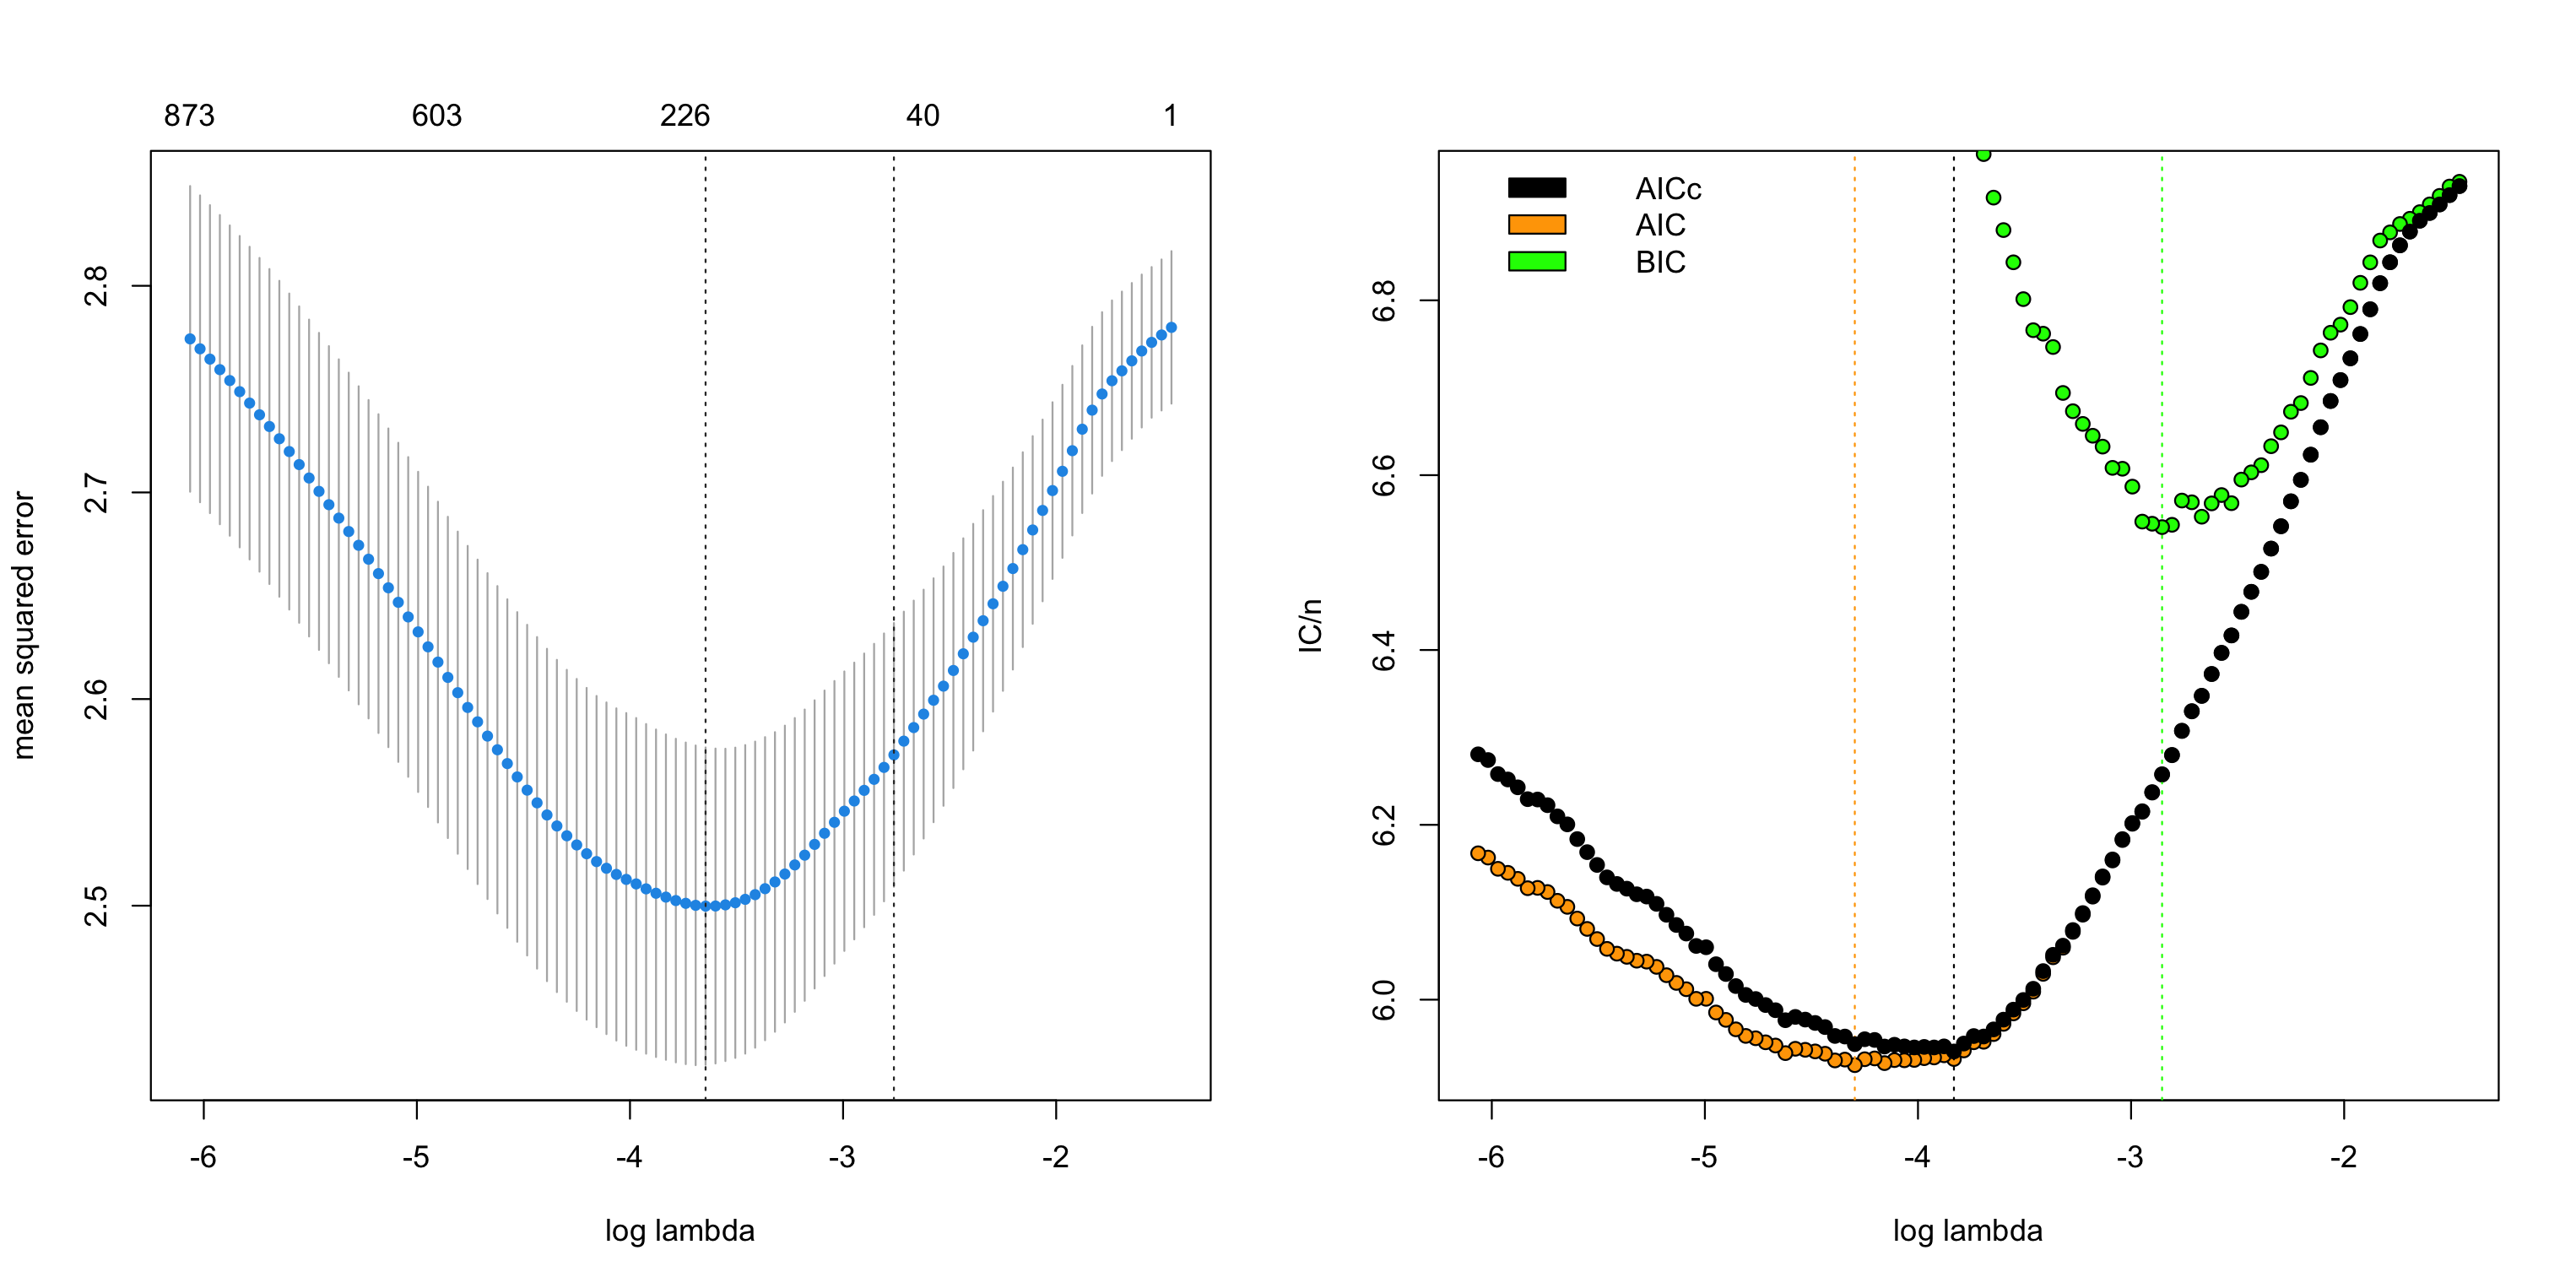

In [41]:
ll <- log(spender$lambda) ## the sequence of lambdas
par(mfrow=c(1,2))
plot(cv.spender)
plot(ll, AIC(spender)/n, 
	xlab="log lambda", ylab="IC/n", pch=21, bg="orange")
abline(v=ll[which.min(AIC(spender))], col="orange", lty=3)
abline(v=ll[which.min(BIC(spender))], col="green", lty=3)
abline(v=ll[which.min(AICc(spender))], col="black", lty=3)
points(ll, BIC(spender)/n, pch=21, bg="green")
points(ll, AICc(spender)/n, pch=21, bg="black")
legend("topleft", bty="n",
	fill=c("black","orange","green"),legend=c("AICc","AIC","BIC"))

We can also mark in the path plot which model (value of the penalty parameter lambda) the various methods (arguments) would prefer most.

In [ ]:
plot(spender, col="grey")
abline(v=ll[which.min(AICc(spender))], col="black", lty=2)
abline(v=ll[which.min(AIC(spender))], col="orange", lty=2)
abline(v=ll[which.min(BIC(spender))], col="green", lty=2)
abline(v=log(cv.spender$lambda.min), col="blue", lty=2)
abline(v=log(cv.spender$lambda.1se), col="purple", lty=2)
legend("topright", bty="n", lwd=1, 
	col=c("black","orange","green","blue","purple"),
	legend=c("AICc","AIC","BIC","CV.min","CV.1se"))

## On to the orange juice

As always, we need to read in the data first.

In [43]:
oj <- read.csv("oj.csv")

This is a cool thing to know about lasso models, easy to miss if you saw conventional econometrics before: It is better to include dummy variables for all categories of a factor, and not leave out any. The following functions will make the missing value, NA, be the reference value in R, so all "real" values will be included.

In [44]:
xnaref <- function(x){
	if(is.factor(x))
		if(!is.na(levels(x)[1]))
			x <- factor(x,levels=c(NA,levels(x)),exclude=NULL)
	return(x) }

naref <- function(DF){
	if(is.null(dim(DF))) return(xnaref(DF))
	if(!is.data.frame(DF)) 
		stop("You need to give me a data.frame or a factor")
	DF <- lapply(DF, xnaref)
	return(as.data.frame(DF))
}

Now we can build the design matrix for all variables. We can make sure we like what we see by checking three rows for example:

In [45]:
oj$brand <- naref(oj$brand)
xbrand <- sparse.model.matrix( ~ brand, data=oj)
xbrand[c(100,200,300),]
oj$brand[c(100,200,300)]

3 x 3 sparse Matrix of class "dgCMatrix"
    (Intercept) brandminute.maid brandtropicana
100           1                .              1
200           1                1              .
300           1                .              .

[1] "tropicana"   "minute.maid" "dominicks"

## Hockey
This is the (very) rare case where you don't start by loading the dataset from a separate data file of your own, as we will use the example data set that came with the software library.

In [46]:
data(hockey)

Let's familiarize ourselves with the data we see. `Goal` is a key dataframe, and there are also separate sparse matrices `player` where players playing together at the time of a goal get the same indicator (1s for the home team, -1 for away). 

In [47]:
head(goal)
player[1:3,2:7]

homegoal season   team.away team.home period differential playoffs
1 0        20022003 DAL       EDM       1       0           0       
2 0        20022003 DAL       EDM       1      -1           0       
3 1        20022003 DAL       EDM       2      -2           0       
4 0        20022003 DAL       EDM       2      -1           0       
5 1        20022003 DAL       EDM       3      -2           0       
6 1        20022003 DAL       EDM       3      -1           0

3 x 6 sparse Matrix of class "dgCMatrix"
     ERIC_BREWER ANSON_CARTER JASON_CHIMERA MIKE_COMRIE ULF_DAHLEN ROB_DIMAIO
[1,]           1            .             1           .          .         -1
[2,]           .            1             .           1         -1          .
[3,]           .            1             .           1          .         -1

We will be build the design matrix from three separate [sparse] matrices.

In [48]:
x <- cbind(config,team,player)

We also pick a binary outcome: whether the goal was a goal for the home team.

In [49]:
y <- goal$homegoal

For a lasso model without cross-validation (so information criteria only), we can use the basic command, only paying attention here not to shrink [penalize] the dummies for team configurations and team-seasons.

In [50]:
nhlreg <- gamlr(x, y, verb=TRUE,
	free=1:(ncol(config)+ncol(team)),
	family="binomial", standardize=FALSE)

*** n=69449 observations and p=2776 covariates ***
segment 1: lambda = 0.001289, dev = 8.096e+04, npass = 292
segment 2: lambda = 0.001231, dev = 8.095e+04, npass = 3
segment 3: lambda = 0.001175, dev = 8.094e+04, npass = 3
segment 4: lambda = 0.001121, dev = 8.094e+04, npass = 3
segment 5: lambda = 0.00107, dev = 8.093e+04, npass = 4
segment 6: lambda = 0.001022, dev = 8.092e+04, npass = 4
segment 7: lambda = 0.0009753, dev = 8.091e+04, npass = 3
segment 8: lambda = 0.000931, dev = 8.089e+04, npass = 3
segment 9: lambda = 0.0008887, dev = 8.087e+04, npass = 4
segment 10: lambda = 0.0008483, dev = 8.084e+04, npass = 4
segment 11: lambda = 0.0008097, dev = 8.081e+04, npass = 4
segment 12: lambda = 0.0007729, dev = 8.079e+04, npass = 4
segment 13: lambda = 0.0007378, dev = 8.076e+04, npass = 4
segment 14: lambda = 0.0007043, dev = 8.073e+04, npass = 4
segment 15: lambda = 0.0006723, dev = 8.07e+04, npass = 4
segment 16: lambda = 0.0006417, dev = 8.066e+04, npass = 4
segment 17: lambda = 

Let's work with the coefficients for players in the model (with a specific lambda) the default AICc selection would pick.

In [51]:
Baicc <- coef(nhlreg)[colnames(player),]

What do we learn from the intercept? This is the effect on odds that a goal is home rather than away,  regardless of any information about what teams are playing or who is on ice. This is the home ice advantage.  We find that home-ice increases odds you've scored by 8%.

In [52]:
exp(coef(nhlreg)[1])

[1] 1.082354

Next we can look at the player effects, first of all how many are significantly different from zero. Be careful, here "significant" does not mean "statistically significant" in a hypothesis testing sense. Only that the regularization method of lasso left us with coefficient different from zero for this player.  The AICc-preferred regression finds 646 significant player effects.

In [53]:
sum(Baicc!=0)

[1] 646

Here is a smart way to look at the 10 largest coefficients, which here correspond to the top 10 players.

In [54]:
Baicc[order(Baicc, decreasing=TRUE)[1:10]]

PETER_FORSBERG  TYLER_TOFFOLI   ONDREJ_PALAT ZIGMUND_PALFFY  SIDNEY_CROSBY 
     0.7548254      0.6292577      0.6284040      0.4426997      0.4131174 
  JOE_THORNTON  PAVEL_DATSYUK  LOGAN_COUTURE      ERIC_FEHR MARTIN_GELINAS 
     0.3837632      0.3761981      0.3682103      0.3677283      0.3577613

And the worst:

In [55]:
Baicc[order(Baicc)[1:10]]

TIM_TAYLOR  JOHN_MCCARTHY P. J._AXELSSON NICLAS_HAVELID    THOMAS_POCK 
    -0.8643214     -0.5651886     -0.4283811     -0.3854583     -0.3844128 
 MATHIEU_BIRON  CHRIS_DINGMAN   DARROLL_POWE RAITIS_IVANANS   RYAN_HOLLWEG 
    -0.3512101     -0.3342243     -0.3339906     -0.3129481     -0.2988769

As in the book, we can practice our intuition with an example. For instance, the model says that whenever a goal is scored, Pittsburgh's odds of having scored (rather than scored on) increase by 51% if Sidney Crosby is on the ice.  

In [56]:
exp(Baicc["SIDNEY_CROSBY"])

SIDNEY_CROSBY 
     1.511523

And the Blue Jackets (or Kings, pre 2011-12) odds of having scored drop by around 22% if Jack Johnson is on the ice.

In [57]:
exp(Baicc["JACK_JOHNSON"])

JACK_JOHNSON 
   0.7813488

Please pay attention to the discussion why we did not standardize the variables in this special case. We did not do that because all variables were 0-or-1 here.

Without `standardize=FALSE`, we'd be multiplying the penalty for each coefficient (player effect) by that player's standard deviation in onice. For a binary variable, the variance is just the product of the probability of occurence and its complement, so p(1-p). The standard deviation is the square root of this.

The players with big SD in onice are guys who play a lot. Players with small SD are those who play little (almost all zeros).  

So weighting penalty by SD in this case is exactly what you don't want: a bigger penalty for people with many minutes on ice, a smaller penalty for those who seldom play.  Indeed, running the regression without `standardize=FALSE` leads to a bunch of farm teamers coming up tops. Hockey fans might check this by looking at these names.

In [58]:
nhlreg.std <-  gamlr(x, y, 
	free=1:(ncol(config)+ncol(team)), family="binomial")
Bstd <- coef(nhlreg.std)[colnames(player),]
Bstd[order(Bstd, decreasing=TRUE)[1:10]]

JEFF_TOMS       RYAN_KRAFT     COLE_JARRETT   TOMAS_POPPERLE 
       1.7380706        1.4826419        1.2119318        1.1107806 
  DAVID_LIFFITON ALEXEY_MARCHENKO     ERIC_SELLECK      MIKE_MURPHY 
       1.0974872        1.0297324        1.0060015        0.9600939 
      DAVID_GOVE       TOMAS_KANA 
       0.9264895        0.8792802

Let's do the proper cross-validation here (with default settings but `standardize`)

In [59]:
cv.nhlreg <- cv.gamlr(x, y, 
	free=1:(ncol(config)+ncol(team)),
	family="binomial", verb=TRUE, standardize=FALSE)

fold 1,2,3,4,5,done.


Again, let's plot the deviance and the lasso path over lambda values together (these are saved into the `cv.nhlreg` thing already):

In [ ]:
par(mfrow=c(1,2))
plot(cv.nhlreg)
plot(cv.nhlreg$gamlr)

We can check the log lambdas selected under various criteria. AIC and AICc give exactly the same answer here (because the number of observation is much, much larger than the number of estimated parameters) and both are close to the cross-validated minimizing answer. This is not surprising, as AIC and AICc both try to approximate out-of-sample deviance (mean-squared error here).

In [61]:
log(nhlreg$lambda[which.min(AICc(nhlreg))])
log(nhlreg$lambda[which.min(AIC(nhlreg))])
log(nhlreg$lambda[which.min(BIC(nhlreg))])
log(cv.nhlreg$lambda.min)
log(cv.nhlreg$lambda.1se)

seg55 
-9.165555

seg55 
-9.165555

seg1 
-6.653644

[1] -9.072521

[1] -8.04915

Not surprisingly, we also see for coefficients that the cross-validated minimizing model gives very similar answers to the AICc or AIC-minimizing ones above. So around 600 players having scores different from zero, Forsberg being the best one.

In [62]:
Bcvmin <- coef(cv.nhlreg, select="min")[colnames(player),]
sum(Bcvmin!=0)
sort(Bcvmin,decreasing=TRUE)[1:10]

[1] 601

PETER_FORSBERG   ONDREJ_PALAT  TYLER_TOFFOLI ZIGMUND_PALFFY  SIDNEY_CROSBY 
     0.7471450      0.5846979      0.5795152      0.4098195      0.4061344 
  JOE_THORNTON  PAVEL_DATSYUK  LOGAN_COUTURE      ERIC_FEHR   MATT_MOULSON 
     0.3787554      0.3659722      0.3571907      0.3549986      0.3468833

The 1SE rule accounts for uncertainty about out-of-sample error (the noise between the folds, also reflecting Monte Carlo noise), and thus chooses a simpler model. See that a not much larger log lambda led to half as many coefficients different from zero. Surprisingly or not, even the top ten changes a little.

In [63]:
Bcv1se <- coef(cv.nhlreg)[colnames(player),]
sum(Bcv1se!=0)
sort(Bcv1se,decreasing=TRUE)[1:10]

[1] 176

PETER_FORSBERG     SIDNEY_CROSBY      JOE_THORNTON     PAVEL_DATSYUK 
        0.5784123         0.3130199         0.2793910         0.2563202 
LUBOMIR_VISNOVSKY     ALEX_OVECHKIN   ALEXANDER_SEMIN      RYAN_GETZLAF 
        0.2529728         0.2450342         0.2382147         0.2186677 
     HENRIK_SEDIN    MARIAN_GABORIK 
        0.2093782         0.2092593

BIC is way, way more conservative than all these options. It actually goes with saying nobody is different from average.

In [64]:
Bbic <- coef(nhlreg,select=which.min(BIC(nhlreg)))[colnames(player),]
sum(Bbic!=0)

[1] 0

The BIC is trying to find lambda with the highest probability of having the minimum out-of-sample error, which is subtly different than finding the lambda corresponding to lowest expected OOS error. For example, if there is more uncertainty about OOS error at the lambda with minimal expectation, then it could be that another value with higher expected error but lower uncertainty around this value will have a higher probability of being best. In this case, the BIC says there is much uncertainty at everything other than the null model, so that the null model ends up highest probability of being best.

As an aside: note that the null model here is not just an intercept, but rather includes onice configuration information along with information about the team and season. So the BIC is not saying that no players matter, but rather that it cannot confidently tell them apart from their team's average level of play in a given season.

Finally, check out some plots to compare model selections.

First the sequence of lambdas:

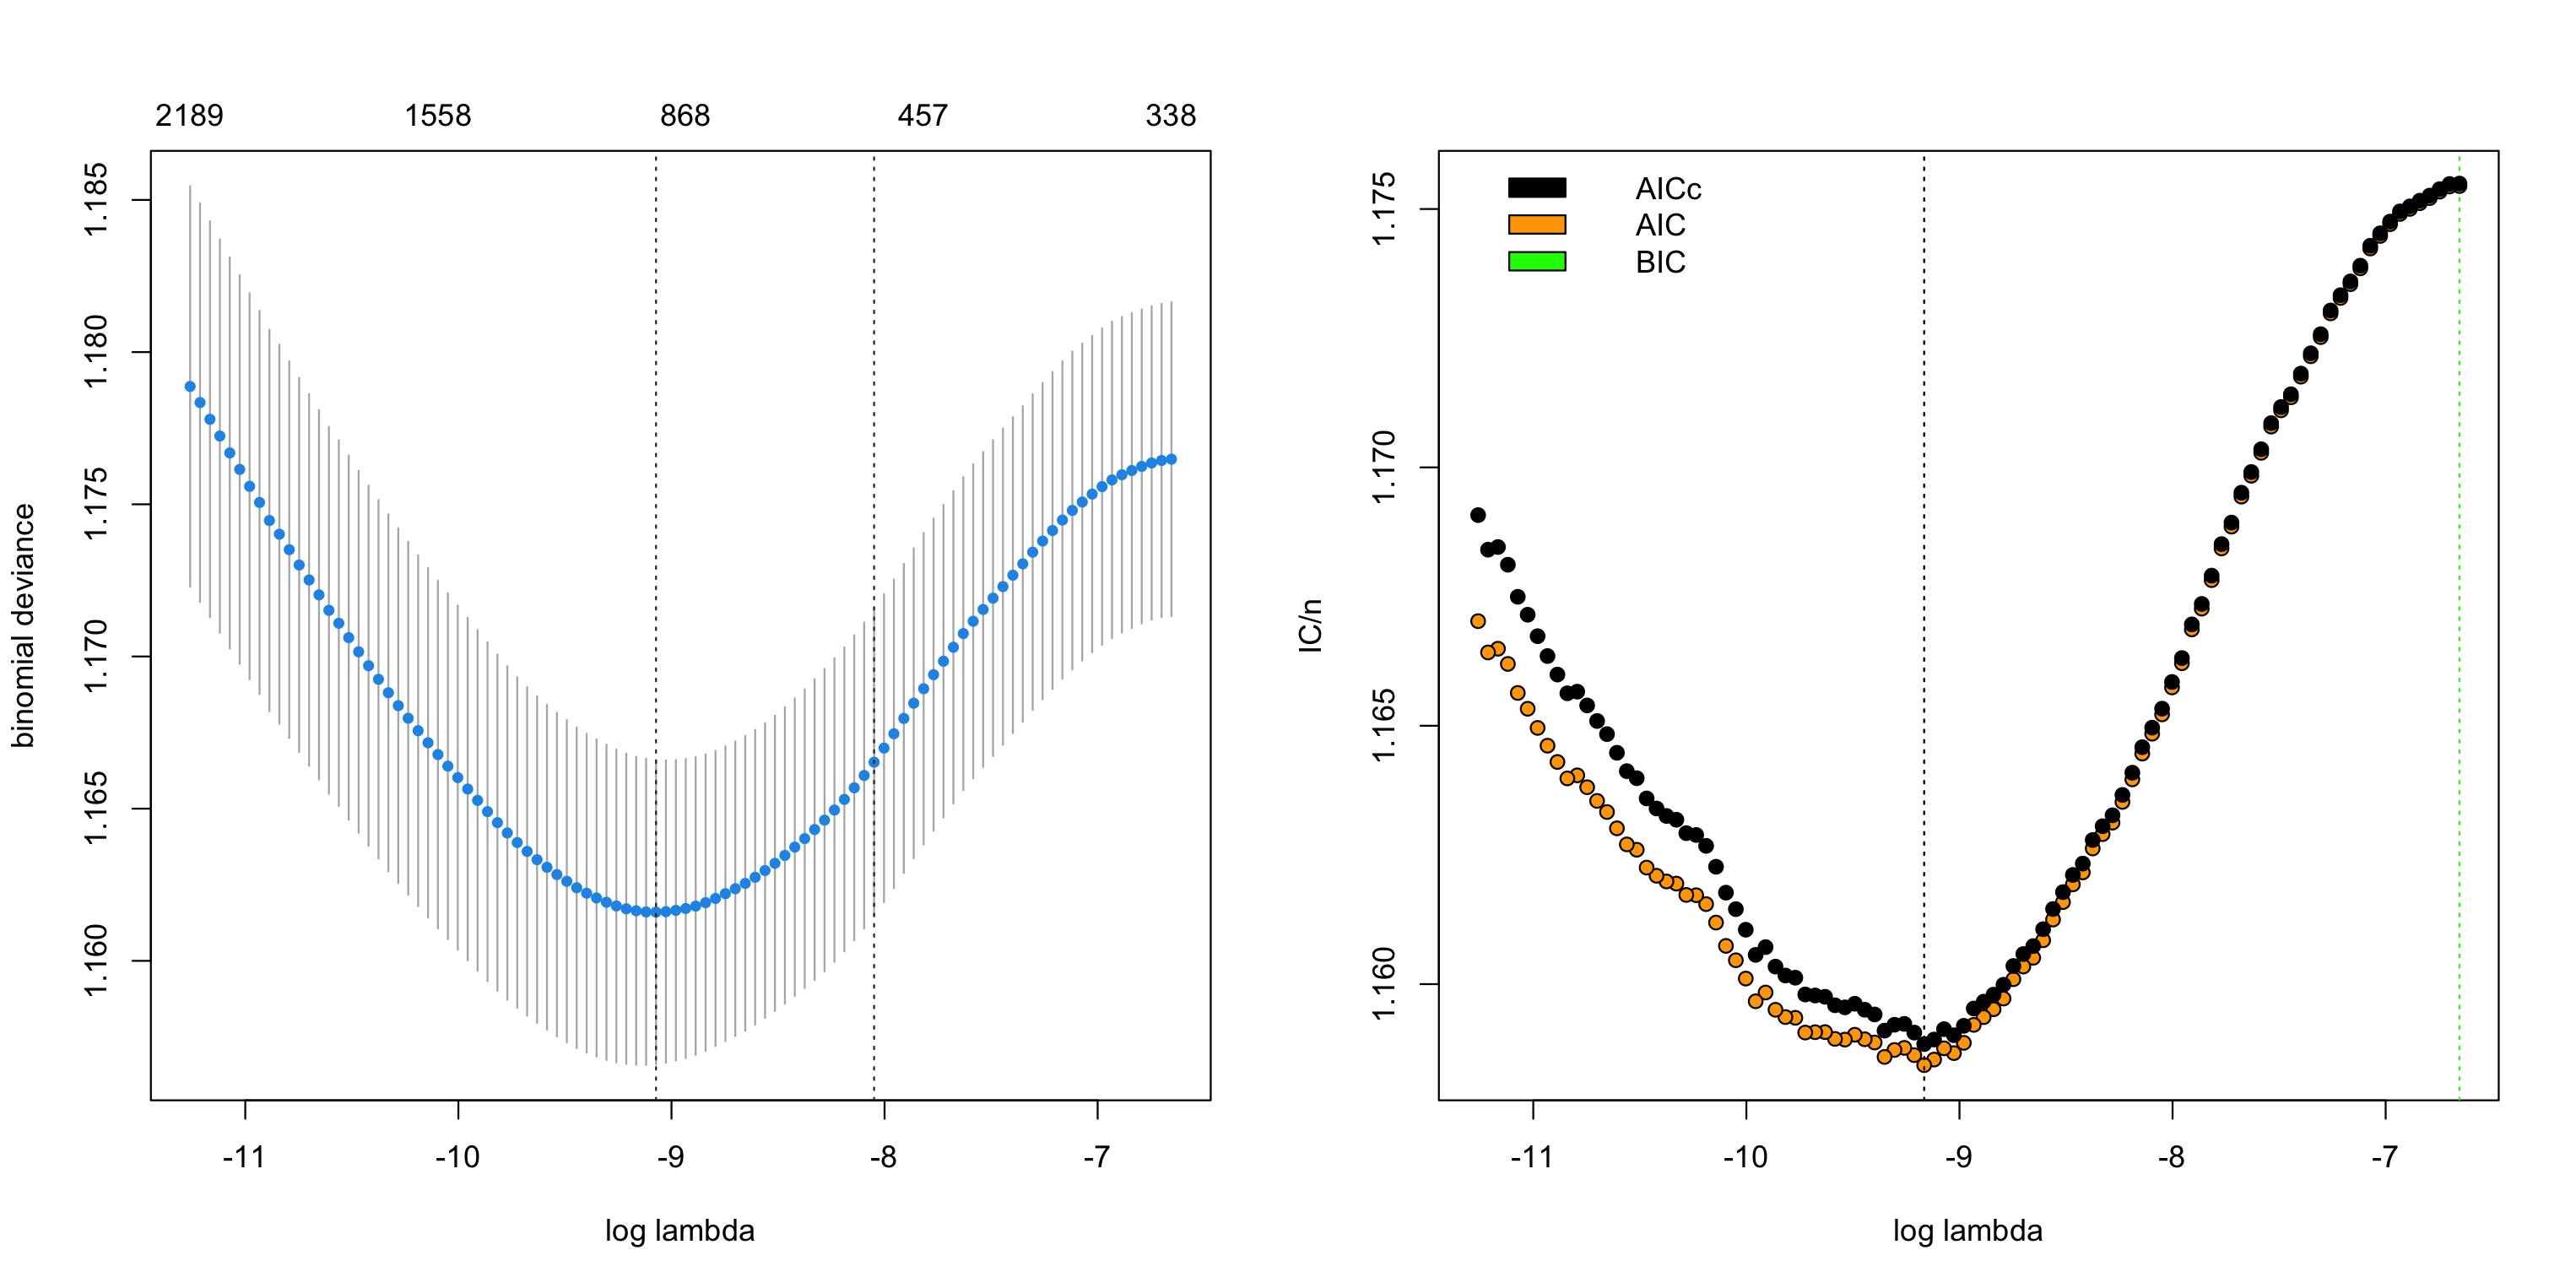

In [65]:
ll <- log(nhlreg$lambda)
n <- nrow(goal)
par(mfrow=c(1,2))
plot(cv.nhlreg)
plot(ll, AIC(nhlreg)/n, 
	xlab="log lambda", ylab="IC/n", pch=21, bg="orange")
abline(v=ll[which.min(AIC(nhlreg))], col="orange", lty=3)
abline(v=ll[which.min(BIC(nhlreg))], col="green", lty=3)
abline(v=ll[which.min(AICc(nhlreg))], col="black", lty=3)
points(ll, BIC(nhlreg)/n, pch=21, bg="green")
points(ll, AICc(nhlreg)/n, pch=21, bg="black")
legend("topleft", bty="n",
	fill=c("black","orange","green"),legend=c("AICc","AIC","BIC"))

Then all these criteria's preferred models/lambdas along the path:

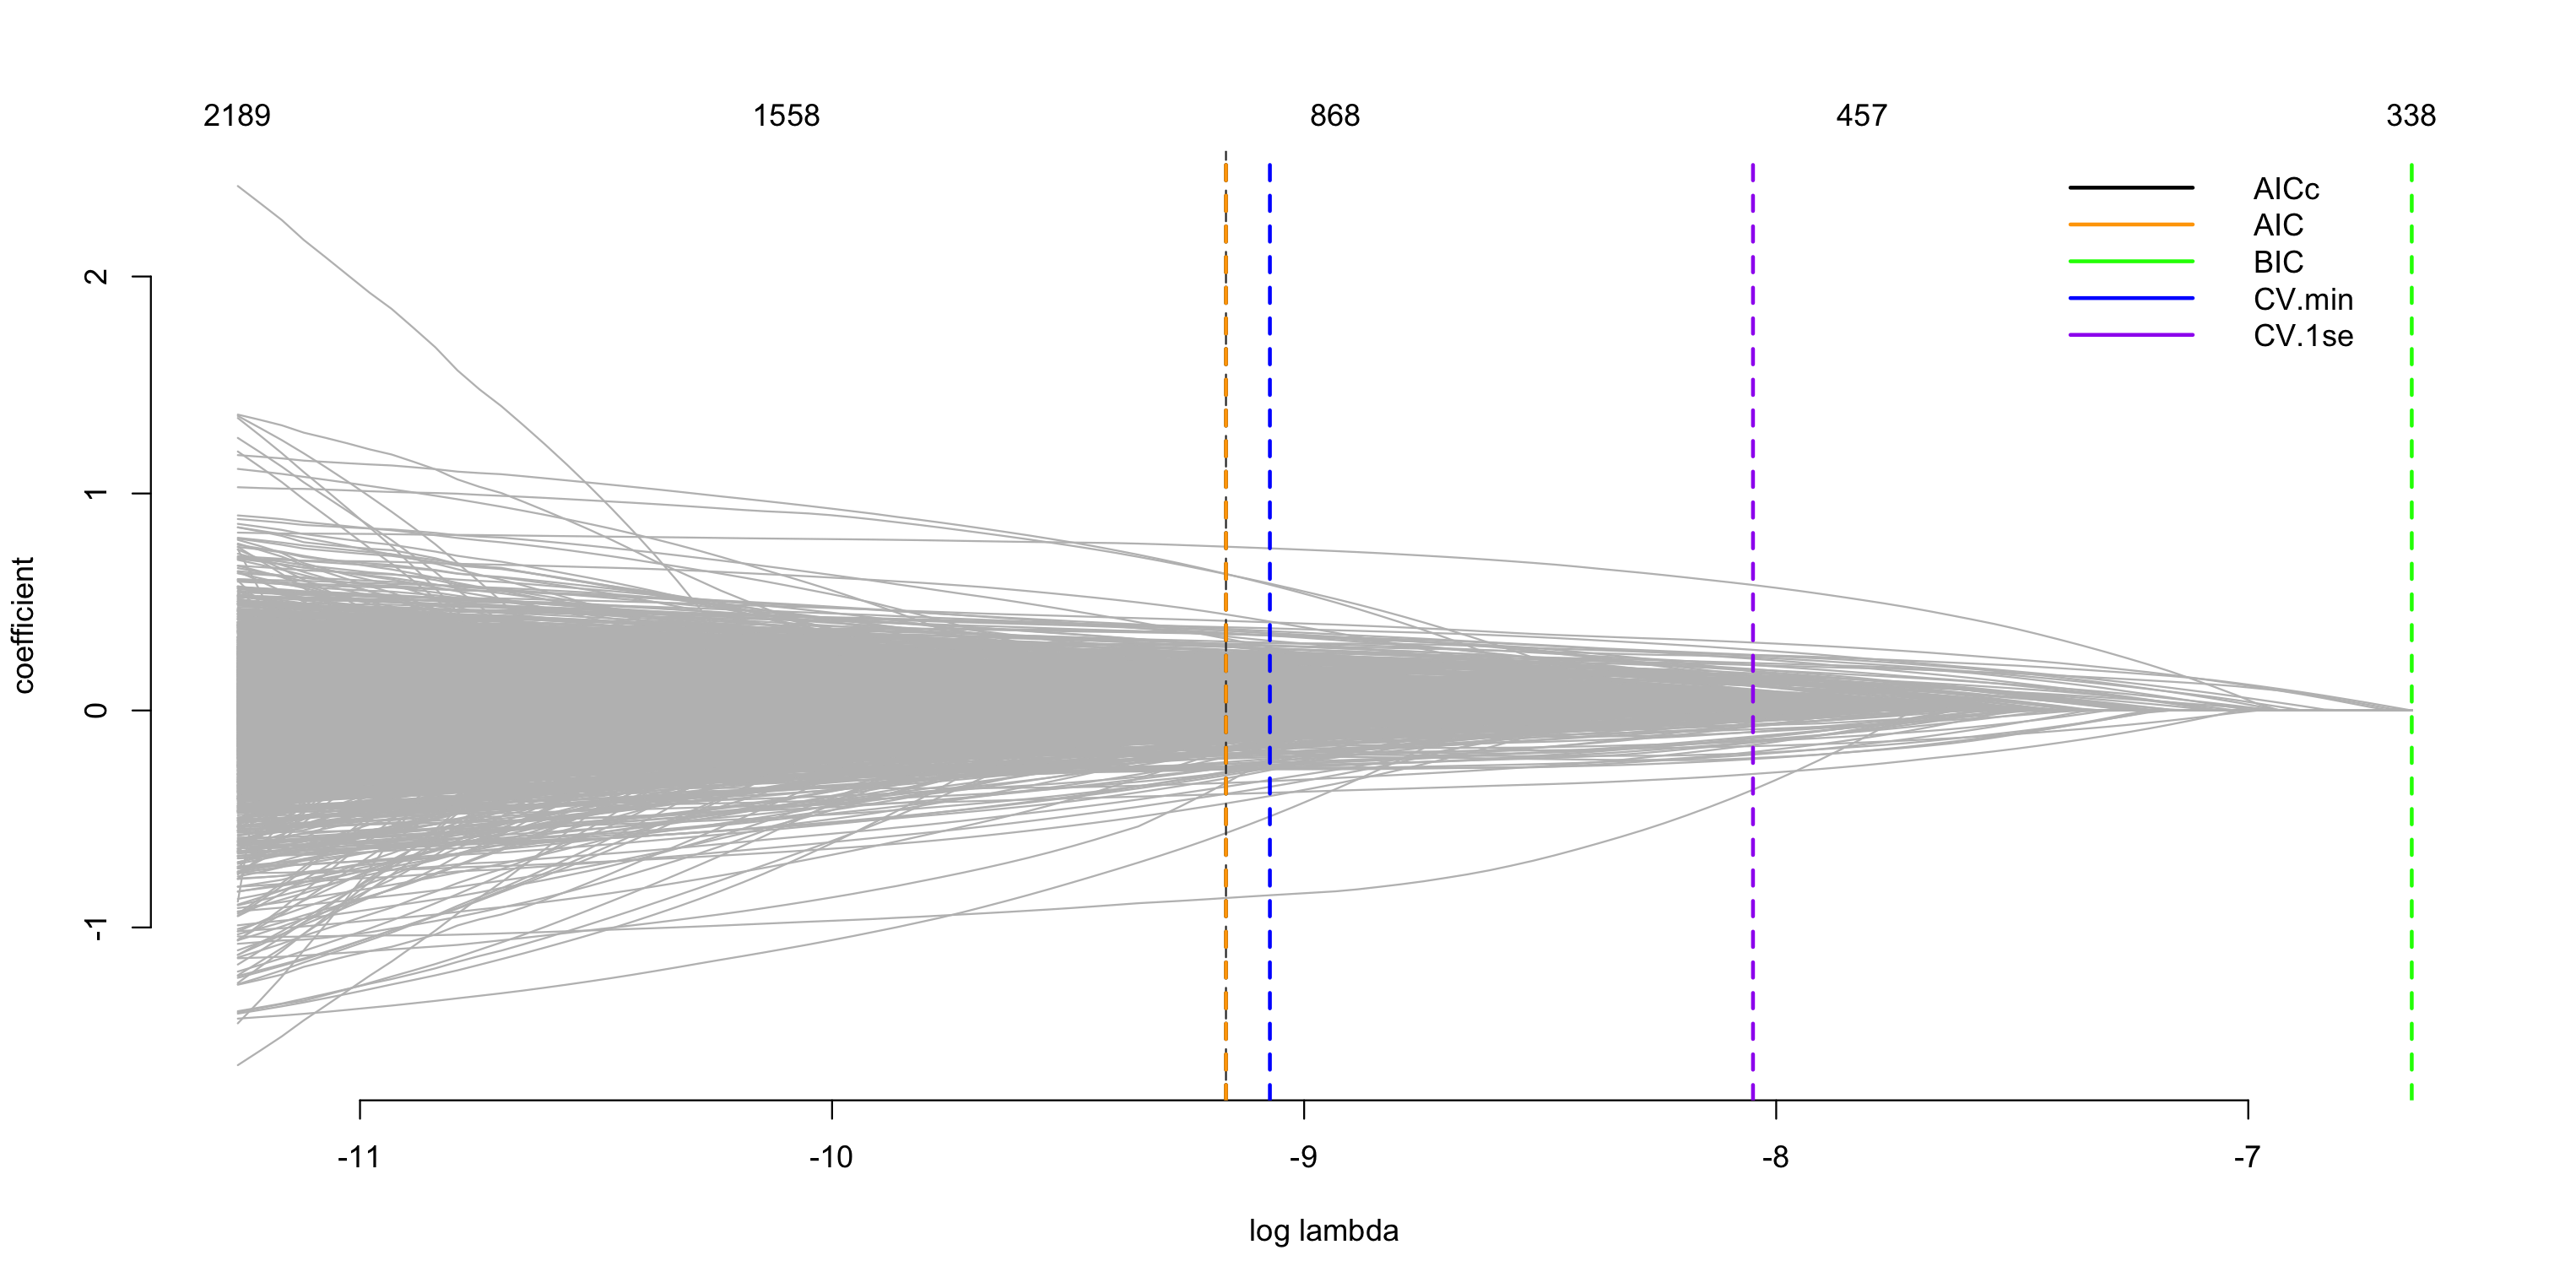

In [66]:
par(mfrow=c(1,1))
plot(nhlreg, col="grey")
abline(v=ll[which.min(AICc(nhlreg))], col="black", lty=2, lwd=2)
abline(v=ll[which.min(AIC(nhlreg))], col="orange", lty=2, lwd=2)
abline(v=ll[which.min(BIC(nhlreg))], col="green", lty=2, lwd=2)
abline(v=log(cv.nhlreg$lambda.min), col="blue", lty=2, lwd=2)
abline(v=log(cv.nhlreg$lambda.1se), col="purple", lty=2, lwd=2)
legend("topright", bty="n", lwd=2, 
	col=c("black","orange","green","blue","purple"),
	legend=c("AICc","AIC","BIC","CV.min","CV.1se"))

## Advanced Topic: Uncertainty Quantification for the Lasso

We'll need the coefficients from the AICc-preferred lasso model from above.

In [67]:
Bhat <- coef(nhlreg)

### A parametric bootstrap
Start with the fitted values of the model we picked here (which came 61st on the lasso path).

In [68]:
Qlowpen <- drop(predict(nhlreg, x, select=61, type="response"))

Then set up a small bootstrap (each iteration will take time to rerun the lasso and pick the AICc-preferred model).

In [69]:
Bparboot <- sparseMatrix(dims=c(nrow(Bhat),0),i={},j={})
B <- 100
for(b in 1:B){
  yb <- rbinom(nrow(x), Qlowpen, size=1)
  fitb <- gamlr(x, yb, 
	free=1:(ncol(config)+ncol(team)), 
	family="binomial", standardize=FALSE)
  Bparboot <- cbind(Bparboot, coef(fitb))
  print(b)
}

[1] 1
[1] 2
[1] 3
[1] 4
[1] 5
[1] 6
[1] 7
[1] 8
[1] 9
[1] 10
[1] 11
[1] 12
[1] 13
[1] 14
[1] 15
[1] 16
[1] 17
[1] 18
[1] 19
[1] 20
[1] 21
[1] 22
[1] 23
[1] 24
[1] 25
[1] 26
[1] 27
[1] 28
[1] 29
[1] 30
[1] 31
[1] 32
[1] 33
[1] 34
[1] 35
[1] 36
[1] 37
[1] 38
[1] 39
[1] 40
[1] 41
[1] 42
[1] 43
[1] 44
[1] 45
[1] 46
[1] 47
[1] 48
[1] 49
[1] 50
[1] 51
[1] 52
[1] 53
[1] 54
[1] 55
[1] 56
[1] 57
[1] 58
[1] 59
[1] 60
[1] 61
[1] 62
[1] 63
[1] 64
[1] 65
[1] 66
[1] 67
[1] 68
[1] 69
[1] 70
[1] 71
[1] 72
[1] 73
[1] 74
[1] 75
[1] 76
[1] 77
[1] 78
[1] 79
[1] 80
[1] 81
[1] 82
[1] 83
[1] 84
[1] 85
[1] 86
[1] 87
[1] 88
[1] 89
[1] 90
[1] 91
[1] 92
[1] 93
[1] 94
[1] 95
[1] 96
[1] 97
[1] 98
[1] 99
[1] 100


We can try any player, and invert its extreme t-statistics around the point estimate (the top error will give the lower end of the confidence interval):

In [70]:
WHO <- "SIDNEY_CROSBY"
fB <- exp(Bhat[WHO,])
tval <- quantile(exp(Bparboot[WHO,]), c(.95,.05))
2*fB - tval

95%       5% 
1.405424 1.755758

Or we can repeat the same for the intercept, which we just agreed to be interpreted as the home ice advantage here.

In [71]:
fB <- exp(Bhat[1,])
tval <- quantile(exp(Bparboot[1,]), c(.95,.05))
2*fB - tval

95%       5% 
1.068310 1.099706

### Subsampling
Smaller samples than the original can go a surprisingly long way.

Calculate the subsample sizes (which will not be the size for all subsamples, as `n` is not divisible by 4 here).

In [72]:
n <- nrow(x)
B <- 100
( m <- round(n/4) )

[1] 17362

Then collect the odds ratios for hundred subsamples.

In [ ]:
Esubs <- sparseMatrix(dims=c(nrow(Bhat),0),i={},j={})
for(b in 1:B){
	subs <- sample.int(n, m)
	fitb <- gamlr(x[subs,], y[subs], 
		free=1:(ncol(config)+ncol(team)),
		family="binomial", standardize=FALSE)
	print(log(fitb$lambda[which.min(AICc(fitb))]))
	plot(fitb)
	eb <- (exp(coef(fitb)) - exp(Bhat))
	Esubs <- cbind(Esubs,  eb)
	print(b)
}

    seg27 
-7.608565 
[1] 1
    seg33 
-7.769084 
[1] 4
    seg30 
-7.896912 
[1] 35
    seg28 
-7.635004 
[1] 66
    seg19 
-7.207652 
[1] 80
    seg29 
-7.625389 


We can calculate a confidence interval for the intercept (home ice advantage), we just need to remember to scale the t-statistics with the learning rates (and hope that it applies).

In [74]:
thetahat <- exp(Bhat[1,])
tval <- quantile(Esubs[1,], c(.95,.05))
thetahat - tval*sqrt(m)/sqrt(n)

95%       5% 
1.065386 1.093933

Or for a player:

In [75]:
WHO <- "SIDNEY_CROSBY"
thetahat <- exp(Bhat[WHO,])
tval <- quantile(Esubs[WHO,], c(.95,.05))
thetahat - tval*sqrt(m)/sqrt(n)

95%       5% 
1.422289 1.715281

We can also plot the subsampled errors for him:

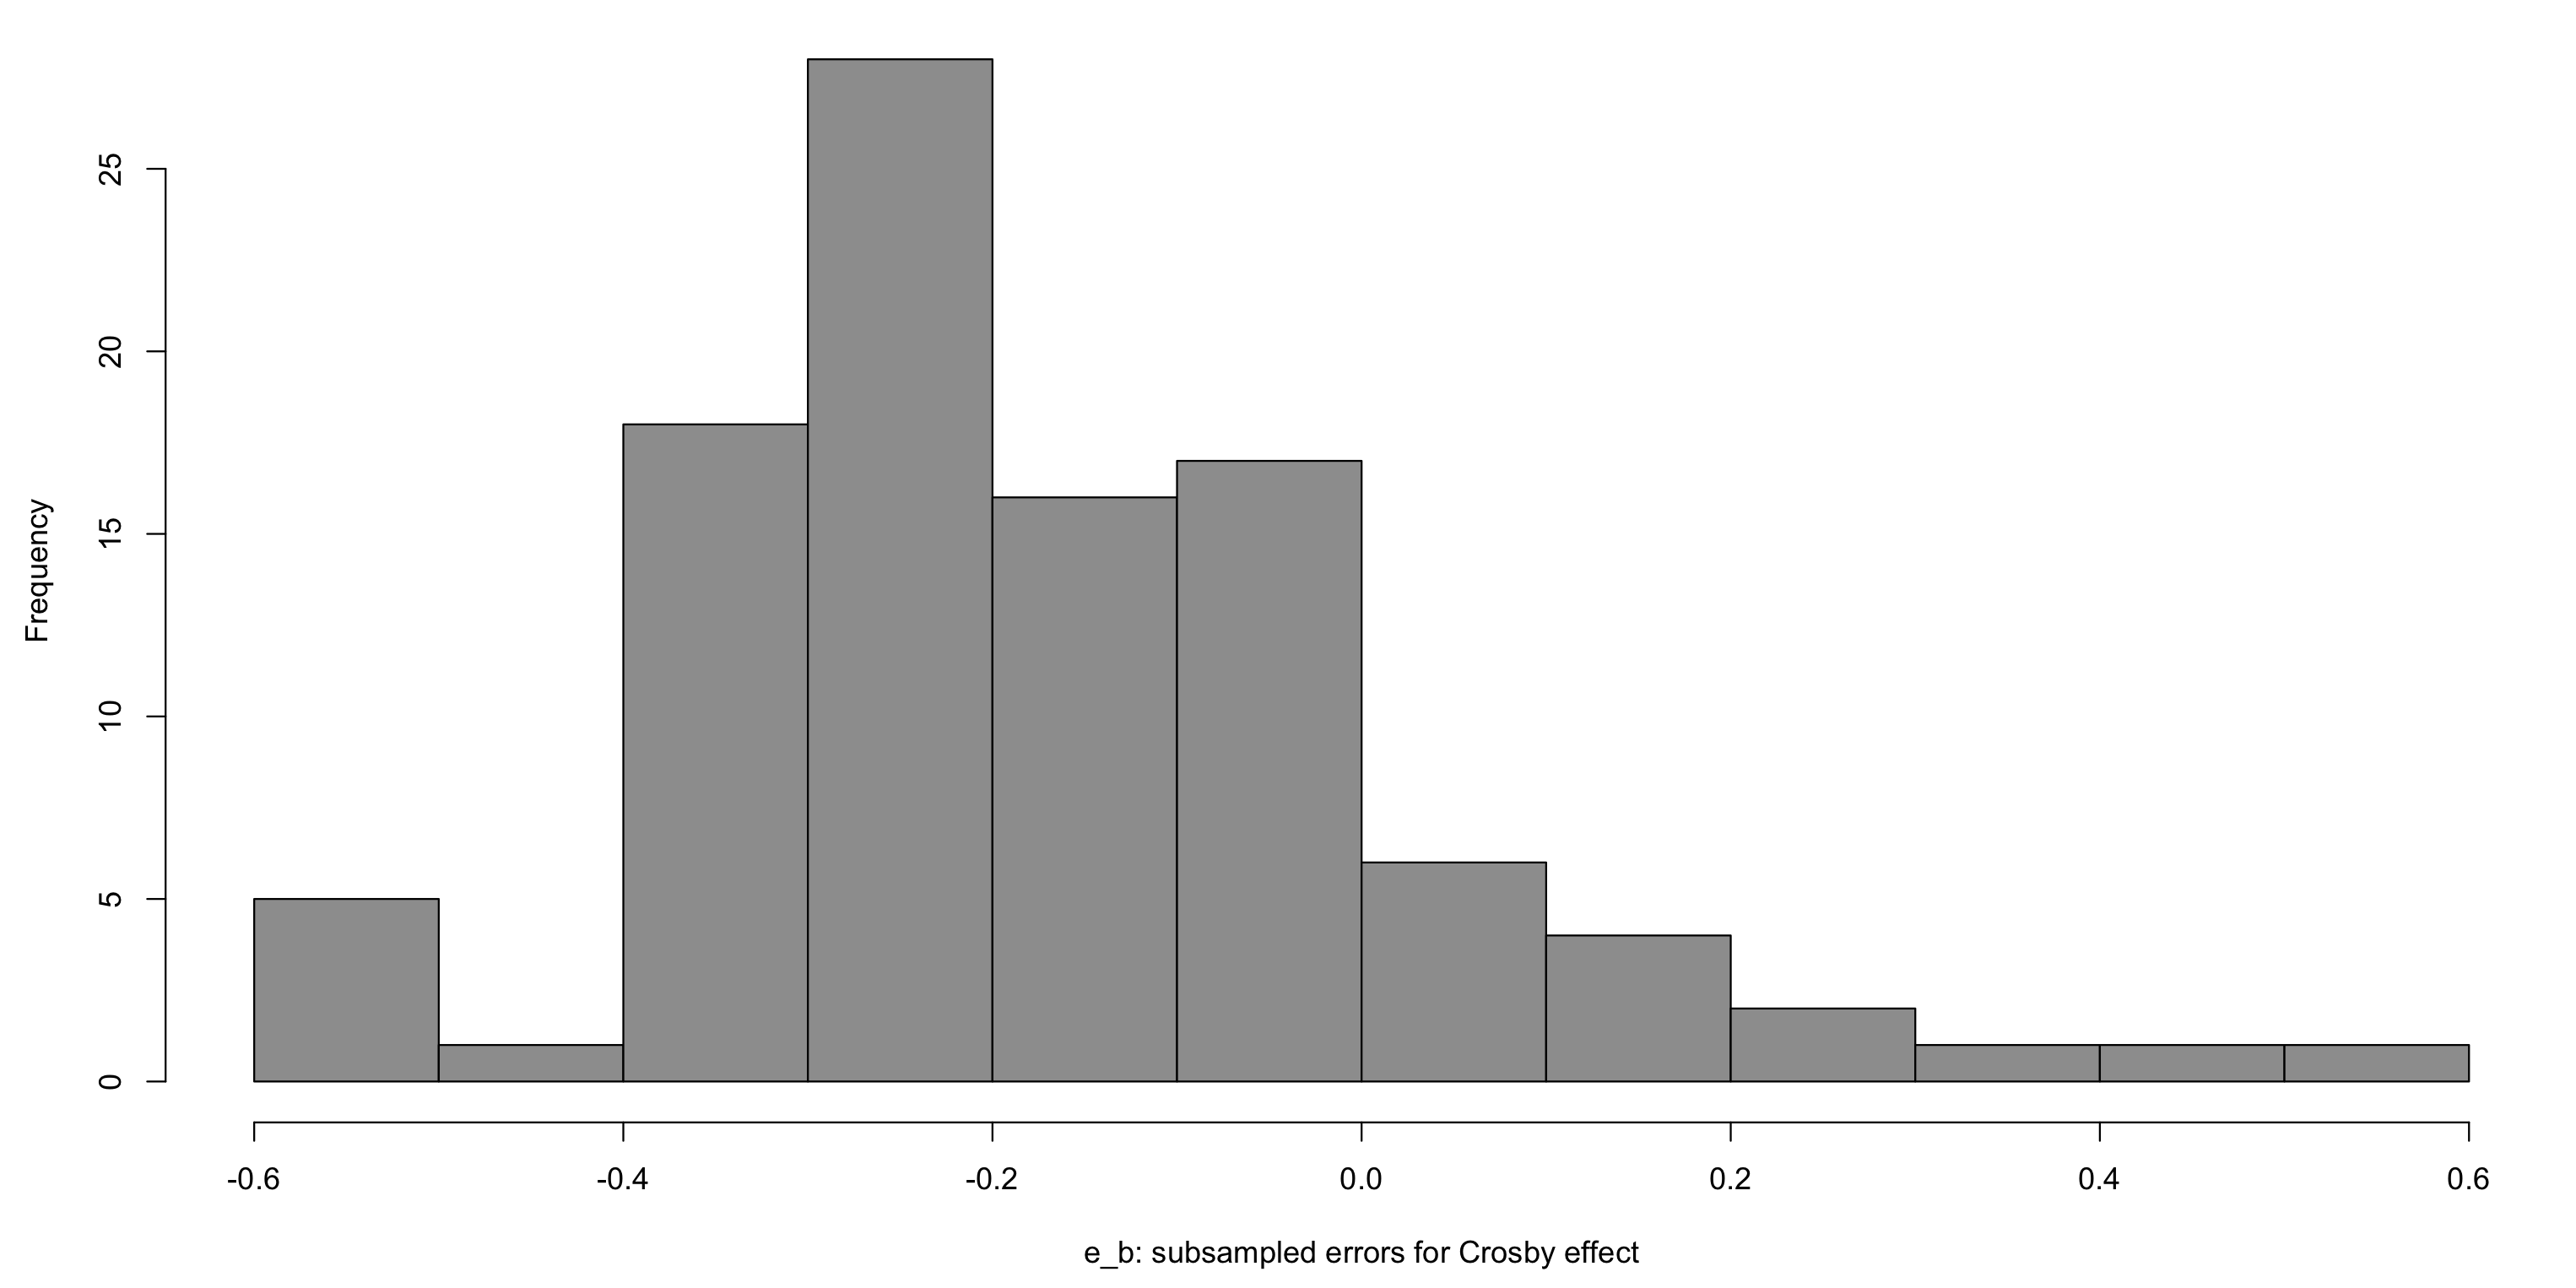

In [76]:
par(mai=c(.9,.9,.1,.1))
hist(Esubs[WHO,],col=8, main="",  xlab="e_b: subsampled errors for Crosby effect")